# AER for HFIR Cycle 502

***
## Basic constants and functions
***

In [1]:
import numpy as np
import sympy as sym
import scipy as sc
import matplotlib.pyplot as plt
import mcstasscript as ms
import scienceplots
import time, math
from scipy.optimize import curve_fit
from scipy.signal import hilbert,convolve
from scipy.fft import fft,fftfreq,ifft
from scipy.integrate import quad,simpson
from matplotlib.animation import FuncAnimation, PillowWriter

plt.style.use(['science', 'notebook', 'grid', 'default', 'bright'])
plot_height = 8
plot_width = plot_height*1.618

SMALL_SIZE,MEDIUM_SIZE,BIGGER_SIZE = 20,30,40
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes', titlesize=BIGGER_SIZE)    # actually gets title font size (glitch in matplotlib?)
plt.rcParams.update({'axes.grid':True})

if False: #Additions to latex preamble for matplotlib:
    plt.rc('text', usetex=True)
    plt.rc('text.latex', preamble=r'\usepackage{amsmath,amsthm,amssymb,amsfonts,braket,siunitx}')
    plt.rcParams["font.family"] = "Computer Modern Roman"
sym.init_printing()

xp = 1/np.sqrt(2)*np.array([[1],[1]]) #spin states
xm = 1/np.sqrt(2)*np.array([[1],[-1]])
yp = 1/np.sqrt(2)*np.array([[1],[1j]])
ym = 1/np.sqrt(2)*np.array([[1],[-1j]])
zp = np.array([[1],[0]])
zm = np.array([[0],[1]])

sx = np.array([[0,1],[1,0]]) #Pauli operators
sy = np.array([[0,-1j],[1j,0]])
sz = np.array([[1,0],[0,-1]])

G = -1.832471e8    #gyromagnetic ratio of neutron (rad/T/m^2)
M = 1.674927e-27    #mass of neutron (kg)
HBAR = 1.054571e-34    #plancks constant (kg m^2/s)
CL = G/(HBAR*2*np.pi)*M*1e-10    #Larmor phase constant (T^-1 m^-1 AA^-1)

In [2]:
def get_SS_focus(harm,Ls,res,ml,a,L):
    """Returns SESANS magnetic field focuing condtion (T)."""
    return 2*np.pi*harm*Ls/(res/1e3)/(CL*lam*a*(L[1] - L[0]))

def cos(x,amp,freq,phase,shim):
    """Simple cosine with shim."""
    return amp*np.cos(x*freq + phase) + shim

def pol_sc(x,A,B,freq):
    """Linear combination of sine and cosine."""
    return A*np.cos(x*freq) + B*np.sin(x*freq)

def quad_cos(x,amp,freq,qfreq,phase,shim):
    """Cosine with quadratic frequency and shim."""
    return amp*np.cos(x*freq + x**2*qfreq + phase) + shim

def g_cos(x,amp,freq,phase,shim,mean,sigma):
    """Cosine with Gaussian envelope and shim."""
    return amp*np.exp(-(x - mean)**2/2/sigma**2)*np.cos(x*freq + phase) + shim

def quad(x,a,b,c):
    """Returns quadratic for peak fitting."""
    return a*x**2 + b*x + c

def sample_factor(x,r,ls,ld):
    """Returns tupule of sample seen by pixel x."""
    return -r/2 - (1 -ls/ld)*x, r/2 - (1 -ls/ld)*x

In [3]:
I1,I2,I3,I4,x,phi = sym.symbols('I_1,I_2,I_3,I_4,x,phi', real=True)
L1,L2,L3,L4,a,b,lam,larm,delta = sym.symbols('L_1,L_2,L_3,L_4,a,b,lambda,c_L,delta', real=True, positive=True)

A = 5e-3 #in Tesla
B = 5e-3 #in Tesla

def MWP(a,b,I,x,phi,inv=False):
    """Field integral from MWP."""
    if inv: a = -a
    return I*(a*x + b*x*phi)

def AER(L1,L2,I1,I2,focus_SS=False):
    """Field integral with option focusing conditions."""
    result = MWP(a,b,I1,x-L1*phi,phi) + MWP(a,b,I2,x-L2*phi,phi)
    if focus_SS: result = result.subs(I2,-I1)
    return result.expand().subs(L1/L2,I2/I1).collect([a,b]).simplify() 

def double_AER(L1,L2,L3,L4,I1,I2,I3,I4,focus_SS=False):
    """Field integral with option focusing conditions."""
    result = MWP(a,b,I1,x-L1*phi,phi) + MWP(a,b,I2,x-L2*phi,phi) + \
                MWP(a,b,I3,x-L3*phi,phi) + MWP(a,b,I4,x-L4*phi,phi)
    if focus_SS: result = result.subs([(I2,I1),(I3,-I1),(I4,-I1)])
    return result.expand().collect([a,b]).simplify() 

display(AER(L1,L2,I1,I2,focus_SS=True))
display(double_AER(L1,L2,L3,L4,I1,I2,I3,I4,focus_SS=True))

***
## Building the beamline
***

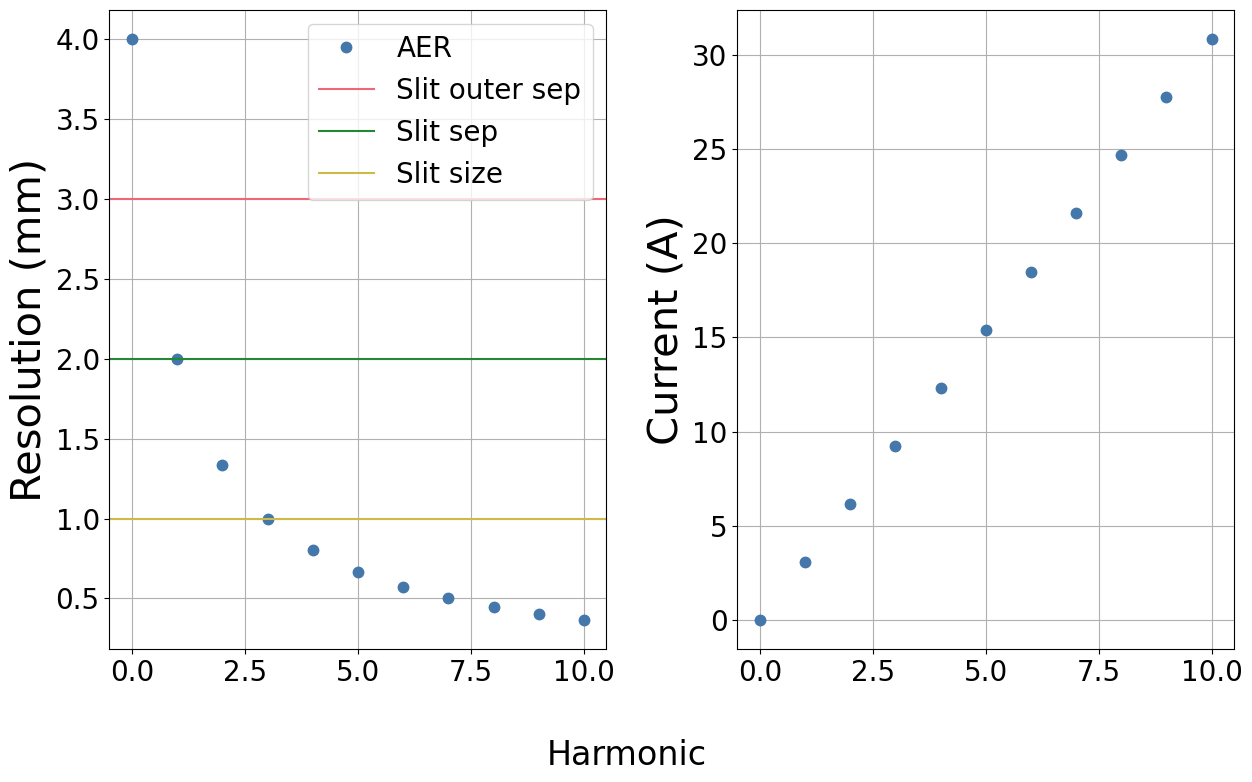

Wavelength: 5.5 p/m  0.055 (Angstroms)
Aperture diameter: 10.0 (mm)
Midpoint distances from MWP to detector: [1.9 1.5] (m)
Geometric resolution: 4.0 (mm) 

MWP currents for first and last harmonic: [ 3.083 30.828] (amps)
Polarizer axis: [1.0, 0.0, 0.0] 

Detector size: [5.0, 5.0] (mm)
[x,y] bin number: [100, 100]
[x,y] bin size: [0.05, 0.05] (mm) 



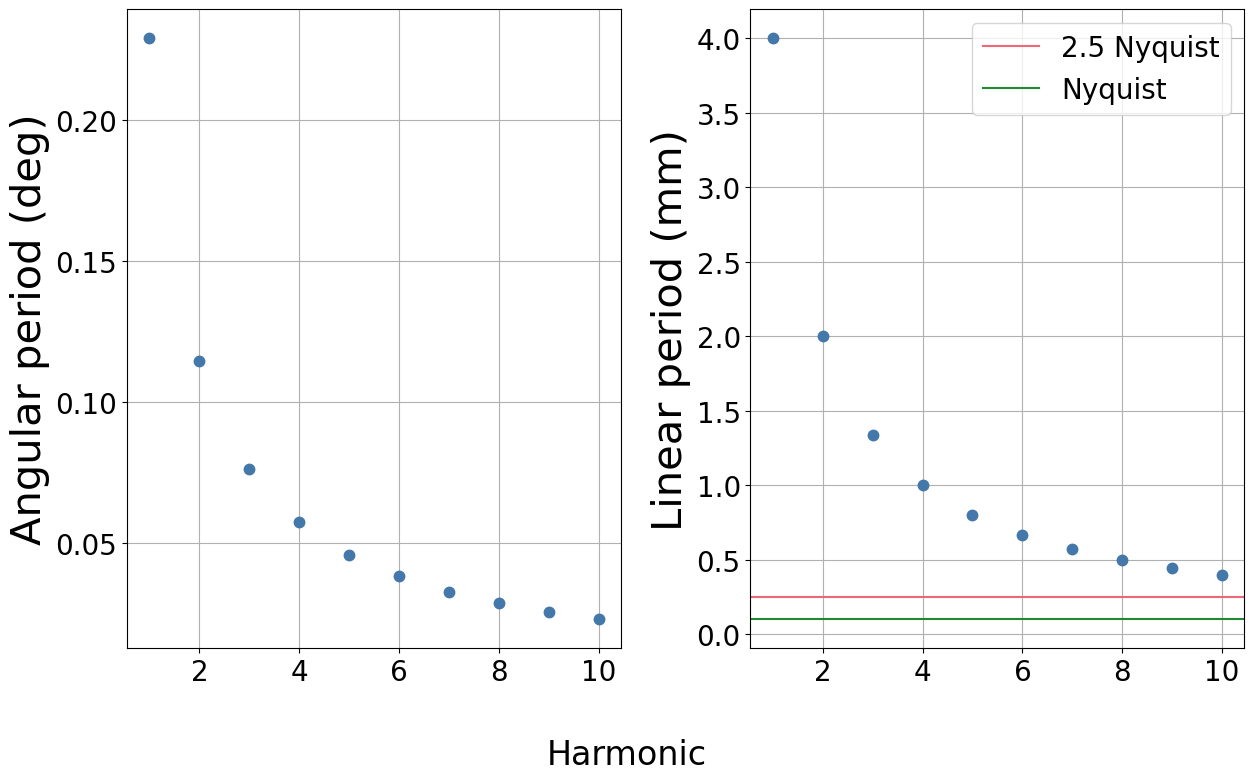

--------------------------------------------------------------------------------
double delta_lambda  = 0.055  // Wavelength spread [AA]
int    low_count     = 0      // if true flips analyzer direction [N/A]
int    all_off       = 0      // if true turns off all MWPs [N/A]
double cur1          = 0.0    // MWP1 current [Amps]
double cur2          = -0.0   // MWP2 current [Amps]
double BCG           = 0.0    // Center guide field [Gauss]
double polx          = 1.0    // x-component of polarizer [N/A]
double poly          = 0.0    // y-component of polarizer [N/A]
double polz          = 0.0    // z-component of polarizer [N/A]
--------------------------------------------------------------------------------
COMPONENT src = Source_sam(
  radius = 0.005, // [m]
  dist = 2.5, // [m]
  focus_xw = 0.005, // [m]
  focus_yh = 0.005, // [m]
  lambda0 = 5.5, // [AA]
  dlambda = delta_lambda, // [AA]
  I1 = 1000000000000000.0 // [1/(cm**2*sr)]
)
AT (0, 0, 0) RELATIVE origin
COMPONENT pol = Set_pol(

In [5]:
lam = 5.5  #wavelength (AA)
dl = lam*.01
ap_dia = 10.0 #aperature diameter (mm)

strength = 2.5e-3 #mT per amp, experimental
MWP_parm = {'FI0':0.,'a':strength*2,'b':strength*2,'c':.0001,'d':-.22}
MWP_dim = {'x':.02,'y':.02,'z':.1}
CG_dim = {'x':.02,'y':.02,'z':.3}
LG_parm = {'B0':0.0,'Bx':0.0,'By':0.0,'Bz':0.0}

MWP_sep, Lss, Ld = .4, 1.5, 2.5 #beamline parameters (m)
dists = {'pol':.0,'P1':.55,'CG':.65,'P2':.95,'ana':1.15,'sam':Lss,'det':Ld}
assert math.isclose(dists['P2'] - dists['P1'], MWP_sep,rel_tol=1e-2), 'Prisms too far apart!'
L = np.array([Ld-dists['P1']-MWP_dim['z']/2,Ld-dists['P2']-MWP_dim['z']/2])
L1, L2 = L  #naming the distances
Ls = Ld - Lss  #distance from sample to detector

slit_width,slit_hieght,slit_num,slit_offset = 1.,10.,11,.5 #mask parameters (mm)
slit_inner,slit_outer = 22.,40.

res = Ls / (dists['det'] / ap_dia) #geometric resolution (mm)
harms = np.arange(0,11)
currents = get_SS_focus(harms,Ls,res,lam,MWP_parm['a'],L)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(plot_width,plot_height))
ax1.plot(harms,res/(1+harms),'.',ms=15,label='AER')
ax1.axhline(y=3., label='Slit outer sep',color='C1')
ax1.axhline(y=2., label='Slit sep',color='C2')
ax1.axhline(y=1., label='Slit size',color='C3')
ax1.set(ylabel='Resolution (mm)')
ax2.plot(harms,currents,'.',ms=15)
ax2.set(ylabel='Current (A)')
ax1.legend()
fig.supxlabel("Harmonic")
plt.tight_layout()
plt.show()

print(f'Wavelength: {lam} p/m  {round(dl,3)} (Angstroms)')
print(f'Aperture diameter: {ap_dia} (mm)')
print(f'Midpoint distances from MWP to detector: {np.round(L,3)} (m)')
print(f'Geometric resolution: {round(res, 3)} (mm) \n')

c1 = get_SS_focus(harms,Ls,res,lam,MWP_parm['a'],L) #currents (amps)
c2 = -c1
BCG = 0.
print(f'MWP currents for first and last harmonic: {np.round([c1[1],c1[-1]],3)} (amps)')

per_rad = abs(2*np.pi/(CL*lam*MWP_parm['a']*(c1[1:]*L1 + c2[1:]*L2)))
per_lin = np.round([res/i for i in harms[1:]],3)
det_res = .4 #Anger camera bin size (mm)
#det_res = .1 #Timepix3 camera bin size (mm)

pol_dir = [1,0,0] #direction of polarizer (x,y,z)
pol_dir = [i/np.sqrt(sum([j**2 for j in pol_dir])) for i in pol_dir]
print(f'Polarizer axis: {[round(i,3) for i in pol_dir]} \n')

ff = .5
det_x,det_y = ff*ap_dia,ff*ap_dia
#bin_x,bin_y = int(det_x/det_res),int(det_y/det_res)
bin_x,bin_y = 100,100
print(f'Detector size: {[round(i,3) for i in [det_x,det_y]]} (mm)')
print(f'[x,y] bin number: {[round(i,3) for i in [bin_x,bin_y]]}')
print(f'[x,y] bin size: {[round(i,3) for i in [det_x/bin_x,det_y/bin_y]]} (mm) \n')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(plot_width,plot_height))
ax1.plot(harms[1:],per_rad*180/np.pi,'.',ms=15)
ax1.set(ylabel='Angular period (deg)')
ax2.plot(harms[1:],per_lin,'.',ms=15)
ax2.axhline(y=5*det_x/bin_x, label='2.5 Nyquist',color='C1')
ax2.axhline(y=2*det_x/bin_x, label='Nyquist',color='C2')
ax2.set(ylabel='Linear period (mm)')
ax2.legend()
fig.supxlabel("Harmonic")
plt.tight_layout()
plt.show()

sam_ang,sam_offset = 0.0,0.0 #angular and linear offset (degs and mm)

#hdiv_pre_det, vdiv_pre_det = '', ''
hdiv_post_det, vdiv_post_det = 'hdiv limits=[-.25,.25] bins=128', 'vdiv limits=[-.25,.25], bins=128'
hdiv_pre_file, vdiv_pre_file = "\"AER_hdiv_pre.dat\"", "\"AER_vdiv_pre.dat\""
hdiv_post_file, vdiv_post_file = "\"AER_hdiv_post.dat\"", "\"AER_vdiv_post.dat\""
twoD_file = "\"AER_2D.dat\""

print("-"*80)     #Start of instrument definition
AER = ms.McStas_instr('AER_HFIR_2023', author = 'Sam McKay', origin = 'Indiana University')
delta_lambda = AER.add_parameter("double", "delta_lambda", value = dl, comment="Wavelength spread [AA]")
low_count = AER.add_parameter("int", "low_count", value = 0, comment="if true flips analyzer direction [N/A]")
all_off = AER.add_parameter("int", "all_off", value = 0, comment="if true turns off all MWPs [N/A]")
cur1 = AER.add_parameter("double", "cur1", value = c1[0], comment="MWP1 current [Amps]")
cur2 = AER.add_parameter("double", "cur2", value = c2[0], comment="MWP2 current [Amps]")
BCG = AER.add_parameter("double", "BCG", value = BCG, comment="Center guide field [Gauss]")
polx = AER.add_parameter("double", "polx", value = pol_dir[0], comment="x-component of polarizer [N/A]")
poly = AER.add_parameter("double", "poly", value = pol_dir[1], comment="y-component of polarizer [N/A]")
polz = AER.add_parameter("double", "polz", value = pol_dir[2], comment="z-component of polarizer [N/A]")
AER.show_parameters()

print("-"*80)    #Source and polarizer (collimation included via source parameters):
AER.add_component("origin","Progress_bar")
AER.add_component("arm","Arm", AT=[0,0,0], RELATIVE="origin")

src = AER.add_component("src","Source_sam", AT=[0,0,0], RELATIVE="origin")
src.set_parameters(radius=ap_dia/2e3, I1=1e15, lambda0=lam, dlambda="delta_lambda", \
                   focus_xw=det_x/1e3, focus_yh=det_y/1e3, dist=Ld)
print(src)

pol = AER.add_component("pol","Set_pol", AT=[0,0,1e-6], RELATIVE="origin")
pol.set_parameters(px="polx", py="poly", pz="polz")
print(pol)

print("-"*80)    #Magnetic Wollaston prisms:
MWP1 = AER.add_component("MWP1","Pol_MWP_v3", AT=[0,0,dists['P1']], RELATIVE="origin")
MWP1.set_parameters(xwidth=MWP_dim['x'], yheight=MWP_dim['y'], zdepth=MWP_dim['z'], \
                    current="cur1*(1-all_off)", a=MWP_parm['a'], b=MWP_parm['b'])
print(MWP1)

CG = AER.add_component("CG","Pol_constBfield", AT=[0,0,dists['CG']], RELATIVE="origin")
CG.set_parameters(xwidth=CG_dim['x'], yheight=CG_dim['y'], zdepth=CG_dim['z'], \
                    B="BCG*(1-all_off)")
print(CG)

MWP2 = AER.add_component("MWP2","Pol_MWP_v3", AT=[0,0,dists['P2']], RELATIVE="origin")
MWP2.set_parameters(xwidth=MWP_dim['x'], yheight=MWP_dim['y'], zdepth=MWP_dim['z'], \
                    current="cur2*(1-all_off)", a=MWP_parm['a'], b=MWP_parm['b'])
print(MWP2)

print("-"*80)    #Analyzer and slit pattern (sample):
ana = AER.add_component("ana","PolAnalyser_ideal", AT=[0,0,dists['ana']], RELATIVE="origin")
ana.set_parameters(mx="polx*(1-2*low_count)", my="poly*(1-2*low_count)", mz="polz*(1-2*low_count)")
print(ana)

sam = AER.add_component("sam","grating_mask", AT=[sam_offset*1e-3,0,Lss], RELATIVE="origin")
sam.set_parameters(outer=1e-3*slit_outer,inner=1e-3*slit_inner,Tr_len=1e-3*slit_width,Ab_len=1e-3*slit_width,\
                   offset=1e-3*slit_offset,slits=slit_num)
sam.set_ROTATED([0,0,sam_ang])
print(sam)

print("-"*80)    #2D and post-sample divergence detectors
det = AER.add_component("det","PSD_monitor", AT=[0,0,Ld], RELATIVE="origin")
det.set_parameters(nx=bin_x,ny=bin_y,filename=twoD_file,xwidth=det_x*1e-3,yheight=det_y*1e-3)
print(det)

"""hdiv = AER.add_component("hdiv","Monitor_nD", AT=[0,0,Ld+1e-6], RELATIVE="origin")
hdiv.set_parameters(xwidth=0.1,yheight=0.1,options=hdiv_post_det,filename=hdiv_post_file)
print(hdiv)

vdiv = AER.add_component("vdiv","Monitor_nD", AT=[0,0,Ld+2e-6], RELATIVE="origin")
vdiv.set_parameters(xwidth=0.1,yheight=0.1,options=vdiv_post_det,filename=vdiv_post_file)
print(vdiv)"""

print("-"*80)    #Final instrument summary:
AER.show_components()

### Portion of grating seen by beam:

Lower/upper limits: -2.0,2.0
Ls=1.0, Ld=2.5, SF=0.6 R=4.0 (mm)
Lower/upper limits: -0.5,3.5


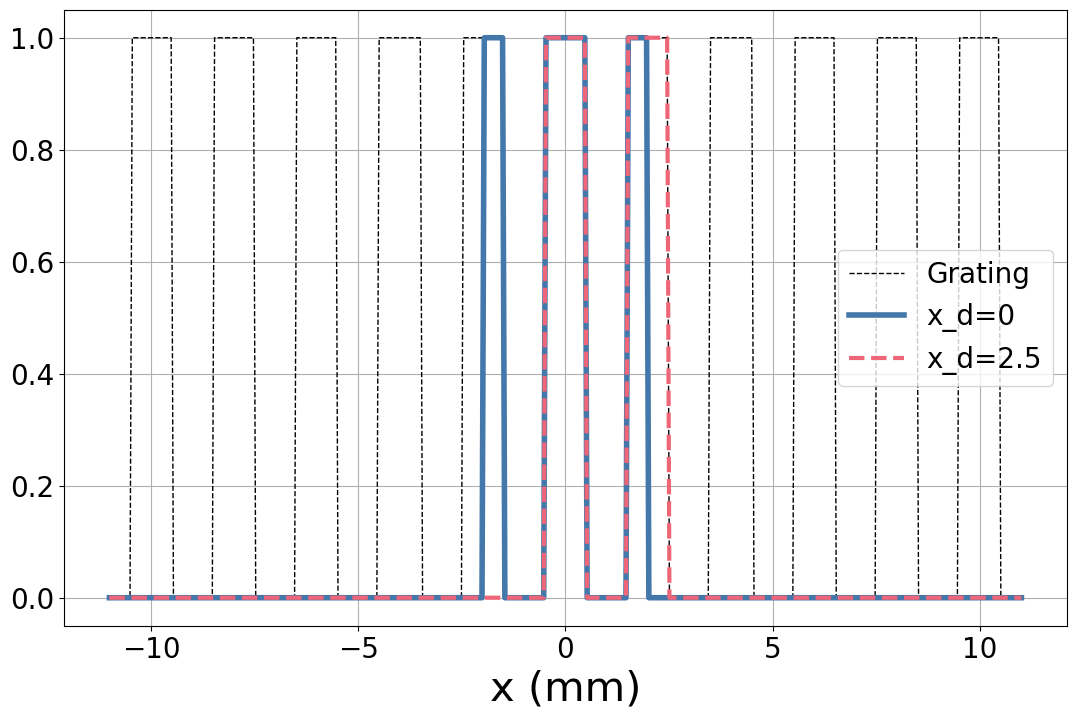

In [25]:
def grating(x,a,t,n,o):
    """Returns 1D transmission function of grating mask."""
    max_x = x[-1]
    result = np.zeros(len(x))
    for indx,i in enumerate(x):
        for s in range(1,n+1):
            if (i > (max_x - o - (a + t)*(s - 1) - t) and i < (max_x - o - (a + t)*(s - 1))):
                result[indx] = 1
    return result

def seen_grating(x,grating,xd,ls,ld,res):
    """Returns the grating as seen by point xd on the detector"""
    lower = -res/2 + (1 - ls/ld)*xd
    upper = res/2 + (1 - ls/ld)*xd
    print(f'Lower/upper limits: {round(lower,3)},{round(upper,3)}')
    mask = [i if (lower<x[indx] and x[indx]<upper) else 0 for indx,i in enumerate(grating)]
    return mask, upper, lower

SEEN,UPPER,LOWER = seen_grating(x_fine,MASK,0,Ls,Ld,Ls*ap_dia/Ld)

print(f'Ls={round(Ls,2)}, Ld={round(Ld,2)}, SF={round(1-Ls/Ld,2)} R={round(res,2)} (mm)')
x_fine = np.linspace(-11.,11.,400,endpoint=True)
MASK = grating(x_fine,slit_width,slit_width,slit_num,.5)
fig = plt.figure(figsize=(plot_width,plot_height))
plt.plot(x_fine,MASK,'--',label='Grating',color='black',linewidth=1)
plt.plot(x_fine,SEEN,linewidth=4,label=f'x_d=0')
xd = [det_x/2]
for x in xd:
    SEEN_xd,UPPER_xd,LOWER_xd = seen_grating(x_fine,MASK,x,Ls,Ld,Ls*ap_dia/Ld) 
    plt.plot(x_fine,SEEN_xd,'--',linewidth=3,label=f'x_d={x}')
plt.xlabel('x (mm)')
plt.legend()
plt.show()

***
## Simulation scans
***


loading system configuration
INFO: Using directory: "C:\Users\xsm\Documents\GitHub\AER-HFIR-1-23\Simulations\triple_slit_vis\hc0.0"
INFO: Regenerating c-file: AER_HFIR_2023.c

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
Info:    'Source_sam' is a contributed component.
Info:    'Pol_MWP_v3' is a contributed component.
Info:    'grating_mask' is a contributed component.
CFLAGS=
INFO: Recompiling: AER_HFIR_2023.exe
AER_HFIR_2023.c: In function 'mcuse_dir':
AER_HFIR_2023.c:3629:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^
AER_HFIR_2023.c: In function 'sighandler':
AER_HFIR_2023.c:5535:64: warning: implicit declaration of function 'getpid' [-Wimplicit-function-declaration]
 

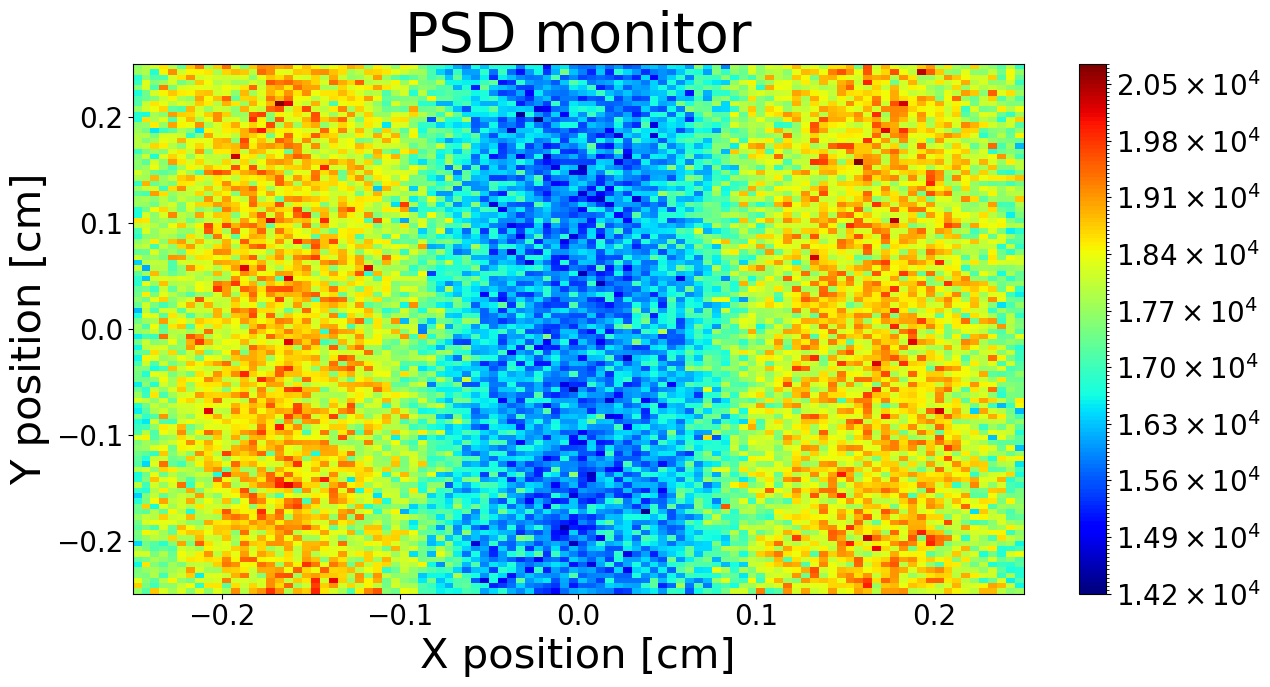


loading system configuration
INFO: Using directory: "C:\Users\xsm\Documents\GitHub\AER-HFIR-1-23\Simulations\triple_slit_vis\hc3.08"
INFO: Regenerating c-file: AER_HFIR_2023.c

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
Info:    'Source_sam' is a contributed component.
Info:    'Pol_MWP_v3' is a contributed component.
Info:    'grating_mask' is a contributed component.
CFLAGS=
INFO: Recompiling: AER_HFIR_2023.exe
AER_HFIR_2023.c: In function 'mcuse_dir':
AER_HFIR_2023.c:3629:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^
AER_HFIR_2023.c: In function 'sighandler':
AER_HFIR_2023.c:5535:64: warning: implicit declaration of function 'getpid' [-Wimplicit-function-declaration]


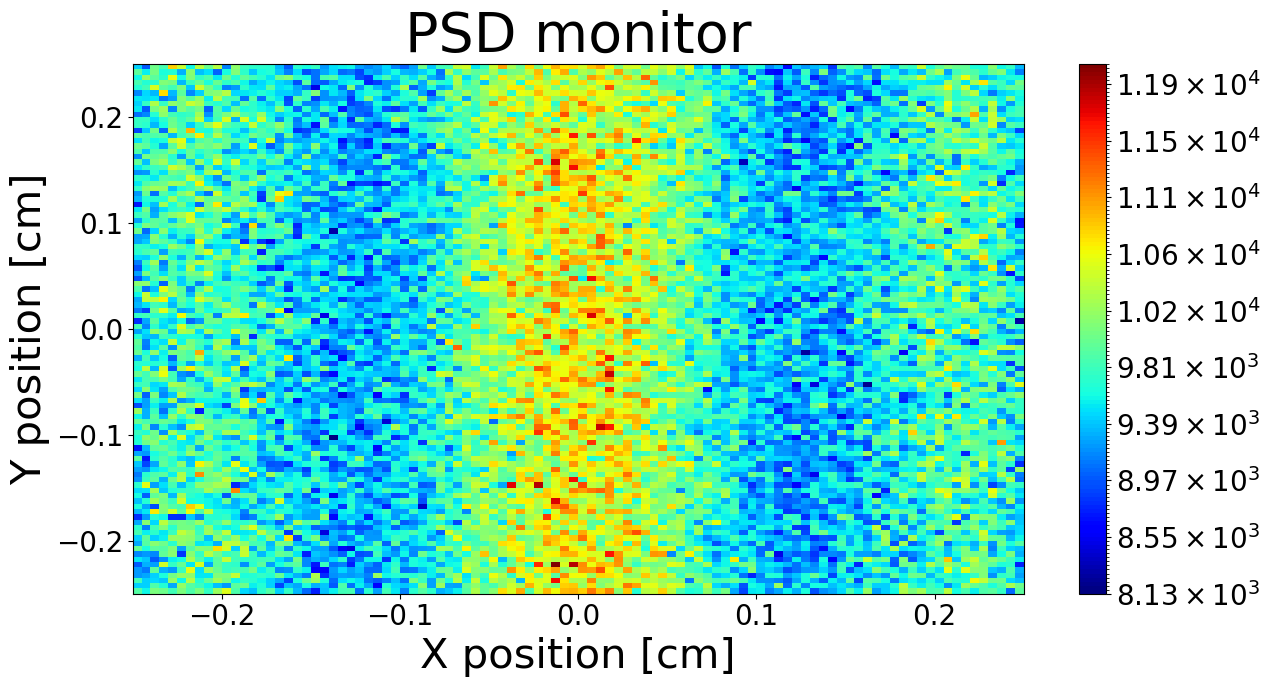


loading system configuration
INFO: Using directory: "C:\Users\xsm\Documents\GitHub\AER-HFIR-1-23\Simulations\triple_slit_vis\lc3.08"
INFO: Regenerating c-file: AER_HFIR_2023.c

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
Info:    'Source_sam' is a contributed component.
Info:    'Pol_MWP_v3' is a contributed component.
Info:    'grating_mask' is a contributed component.
CFLAGS=
INFO: Recompiling: AER_HFIR_2023.exe
AER_HFIR_2023.c: In function 'mcuse_dir':
AER_HFIR_2023.c:3629:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^
AER_HFIR_2023.c: In function 'sighandler':
AER_HFIR_2023.c:5535:64: warning: implicit declaration of function 'getpid' [-Wimplicit-function-declaration]


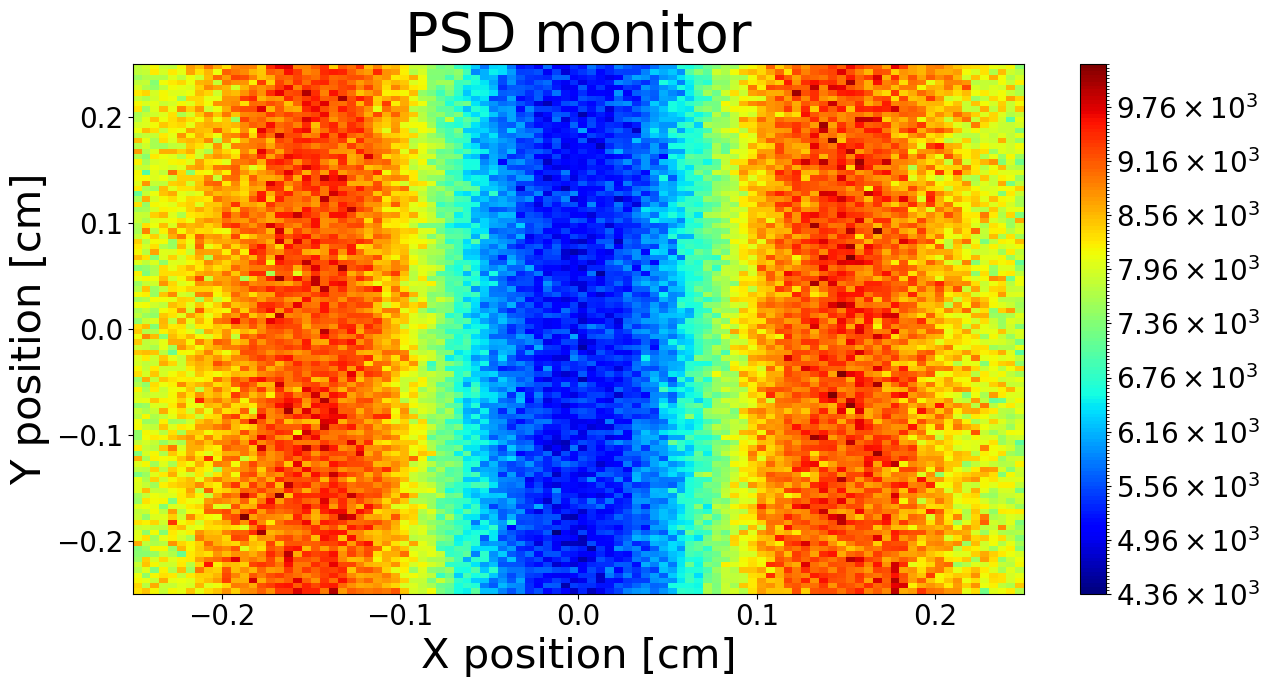


loading system configuration
INFO: Using directory: "C:\Users\xsm\Documents\GitHub\AER-HFIR-1-23\Simulations\triple_slit_vis\hc6.17"
INFO: Regenerating c-file: AER_HFIR_2023.c

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
Info:    'Source_sam' is a contributed component.
Info:    'Pol_MWP_v3' is a contributed component.
Info:    'grating_mask' is a contributed component.
CFLAGS=
INFO: Recompiling: AER_HFIR_2023.exe
AER_HFIR_2023.c: In function 'mcuse_dir':
AER_HFIR_2023.c:3629:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^
AER_HFIR_2023.c: In function 'sighandler':
AER_HFIR_2023.c:5535:64: warning: implicit declaration of function 'getpid' [-Wimplicit-function-declaration]


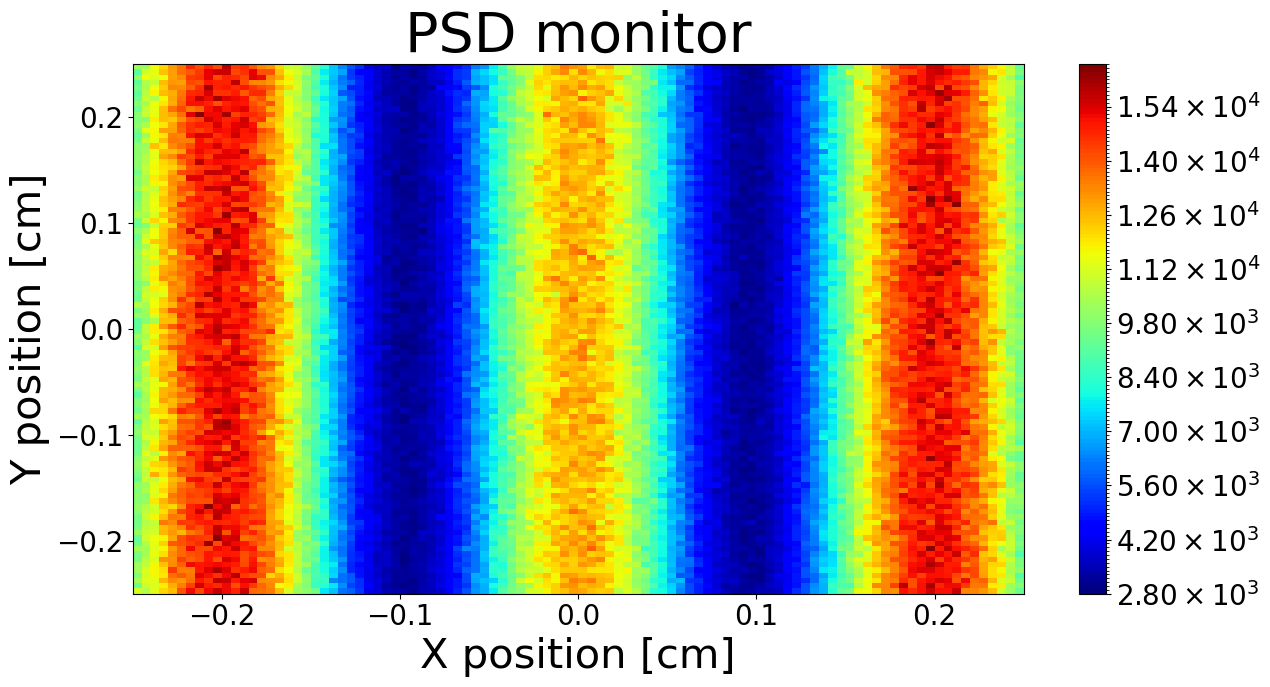


loading system configuration
INFO: Using directory: "C:\Users\xsm\Documents\GitHub\AER-HFIR-1-23\Simulations\triple_slit_vis\lc6.17"
INFO: Regenerating c-file: AER_HFIR_2023.c

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
Info:    'Source_sam' is a contributed component.
Info:    'Pol_MWP_v3' is a contributed component.
Info:    'grating_mask' is a contributed component.
CFLAGS=
INFO: Recompiling: AER_HFIR_2023.exe
AER_HFIR_2023.c: In function 'mcuse_dir':
AER_HFIR_2023.c:3629:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^
AER_HFIR_2023.c: In function 'sighandler':
AER_HFIR_2023.c:5535:64: warning: implicit declaration of function 'getpid' [-Wimplicit-function-declaration]


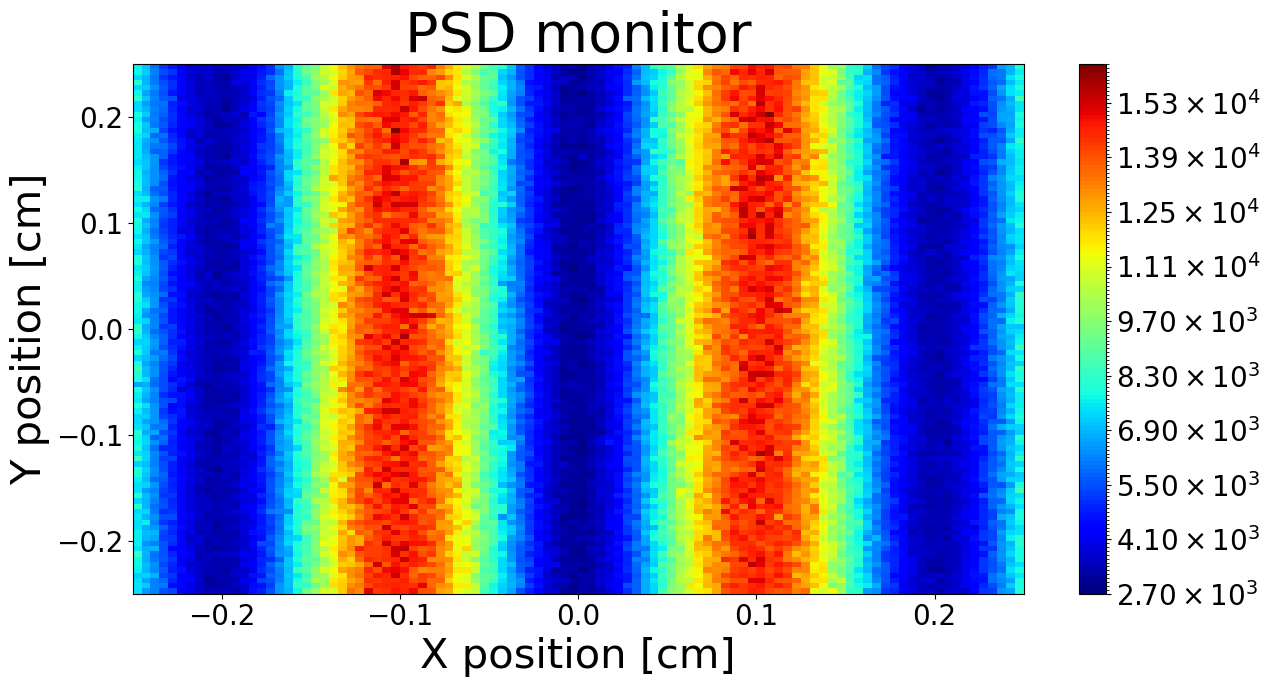


loading system configuration
INFO: Using directory: "C:\Users\xsm\Documents\GitHub\AER-HFIR-1-23\Simulations\triple_slit_vis\hc9.25"
INFO: Regenerating c-file: AER_HFIR_2023.c

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
Info:    'Source_sam' is a contributed component.
Info:    'Pol_MWP_v3' is a contributed component.
Info:    'grating_mask' is a contributed component.
CFLAGS=
INFO: Recompiling: AER_HFIR_2023.exe
AER_HFIR_2023.c: In function 'mcuse_dir':
AER_HFIR_2023.c:3629:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^
AER_HFIR_2023.c: In function 'sighandler':
AER_HFIR_2023.c:5535:64: warning: implicit declaration of function 'getpid' [-Wimplicit-function-declaration]


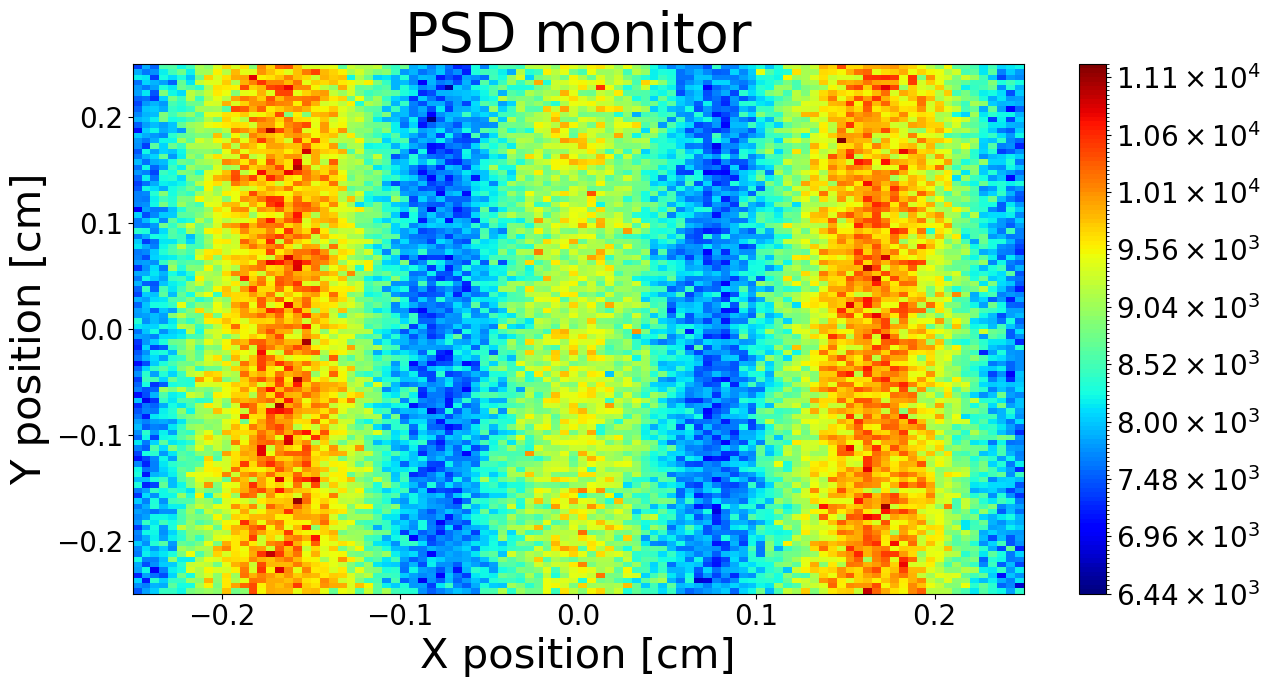


loading system configuration
INFO: Using directory: "C:\Users\xsm\Documents\GitHub\AER-HFIR-1-23\Simulations\triple_slit_vis\lc9.25"
INFO: Regenerating c-file: AER_HFIR_2023.c

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
Info:    'Source_sam' is a contributed component.
Info:    'Pol_MWP_v3' is a contributed component.
Info:    'grating_mask' is a contributed component.
CFLAGS=
INFO: Recompiling: AER_HFIR_2023.exe
AER_HFIR_2023.c: In function 'mcuse_dir':
AER_HFIR_2023.c:3629:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^
AER_HFIR_2023.c: In function 'sighandler':
AER_HFIR_2023.c:5535:64: warning: implicit declaration of function 'getpid' [-Wimplicit-function-declaration]


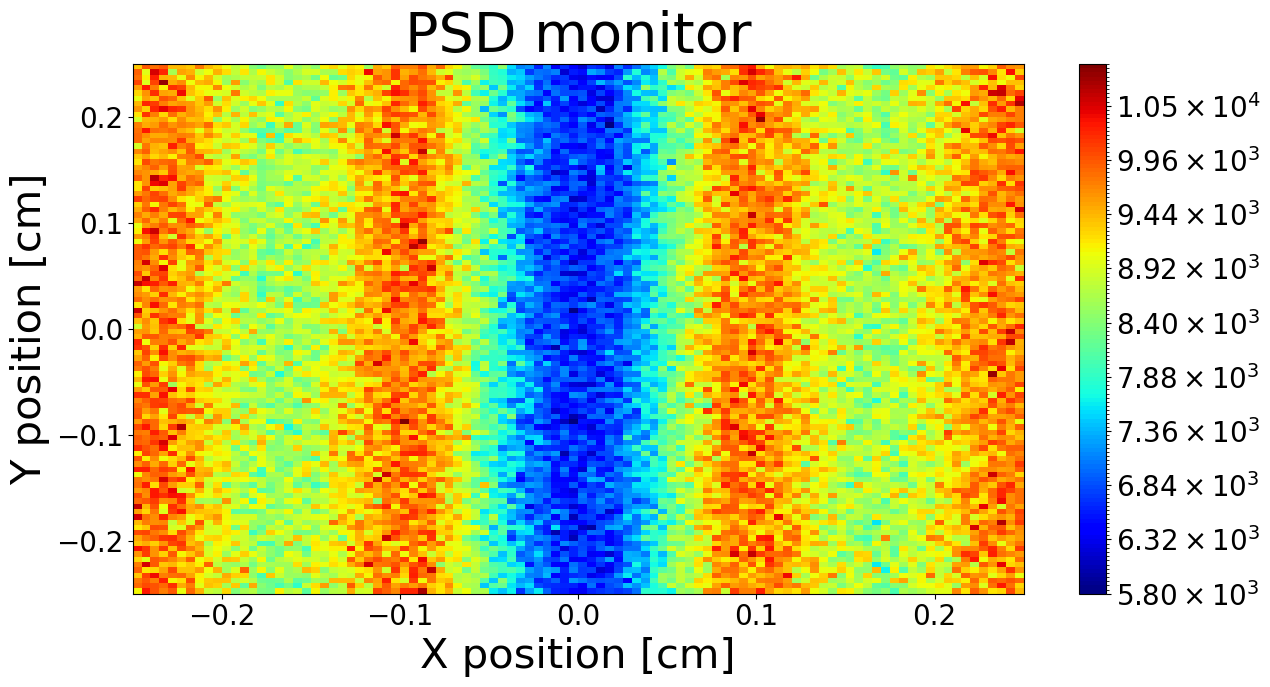


loading system configuration
INFO: Using directory: "C:\Users\xsm\Documents\GitHub\AER-HFIR-1-23\Simulations\triple_slit_vis\hc12.33"
INFO: Regenerating c-file: AER_HFIR_2023.c

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
Info:    'Source_sam' is a contributed component.
Info:    'Pol_MWP_v3' is a contributed component.
Info:    'grating_mask' is a contributed component.
CFLAGS=
INFO: Recompiling: AER_HFIR_2023.exe
AER_HFIR_2023.c: In function 'mcuse_dir':
AER_HFIR_2023.c:3629:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^
AER_HFIR_2023.c: In function 'sighandler':
AER_HFIR_2023.c:5535:64: warning: implicit declaration of function 'getpid' [-Wimplicit-function-declaration]

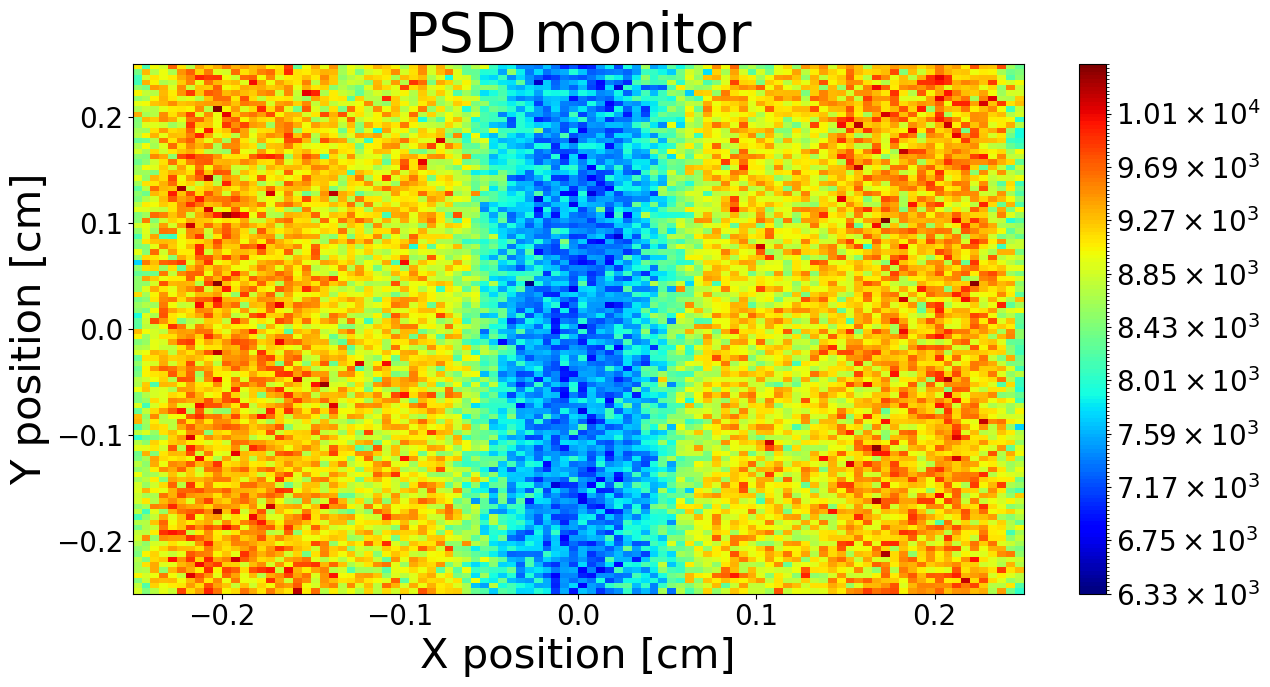


loading system configuration
INFO: Using directory: "C:\Users\xsm\Documents\GitHub\AER-HFIR-1-23\Simulations\triple_slit_vis\lc12.33"
INFO: Regenerating c-file: AER_HFIR_2023.c

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
Info:    'Source_sam' is a contributed component.
Info:    'Pol_MWP_v3' is a contributed component.
Info:    'grating_mask' is a contributed component.
CFLAGS=
INFO: Recompiling: AER_HFIR_2023.exe
AER_HFIR_2023.c: In function 'mcuse_dir':
AER_HFIR_2023.c:3629:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^
AER_HFIR_2023.c: In function 'sighandler':
AER_HFIR_2023.c:5535:64: warning: implicit declaration of function 'getpid' [-Wimplicit-function-declaration]

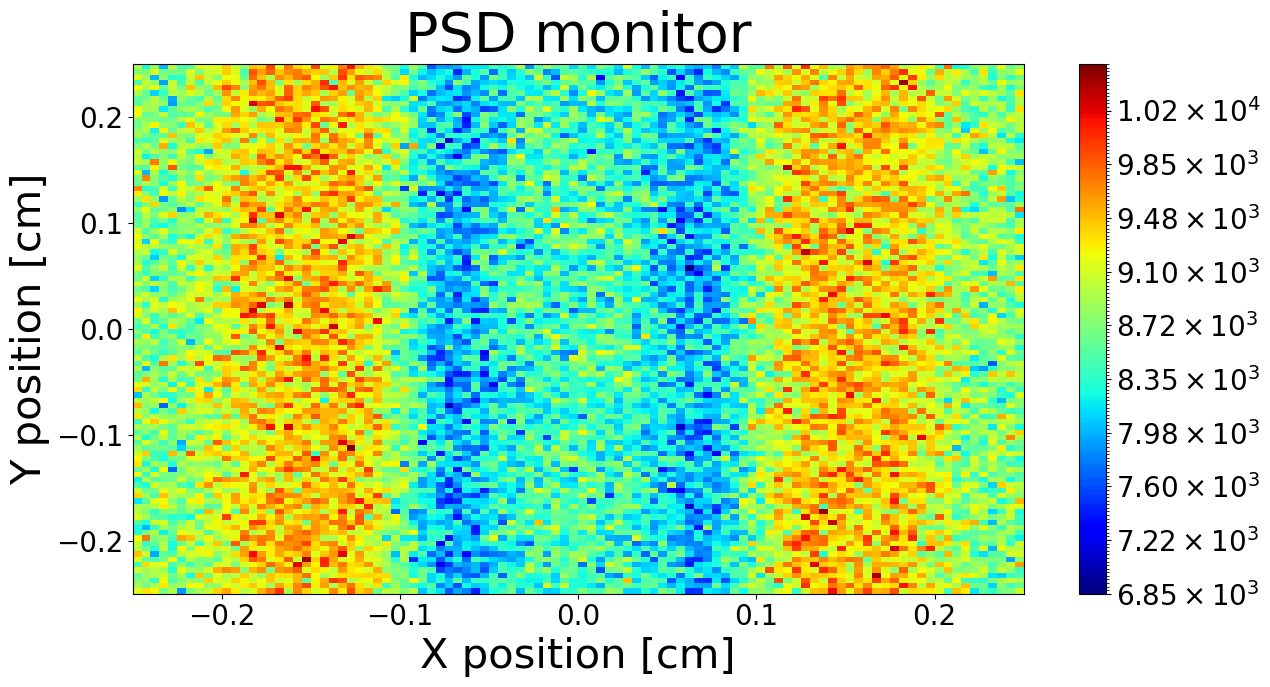


loading system configuration
INFO: Using directory: "C:\Users\xsm\Documents\GitHub\AER-HFIR-1-23\Simulations\triple_slit_vis\hc15.41"
INFO: Regenerating c-file: AER_HFIR_2023.c

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
Info:    'Source_sam' is a contributed component.
Info:    'Pol_MWP_v3' is a contributed component.
Info:    'grating_mask' is a contributed component.
CFLAGS=
INFO: Recompiling: AER_HFIR_2023.exe
AER_HFIR_2023.c: In function 'mcuse_dir':
AER_HFIR_2023.c:3629:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^
AER_HFIR_2023.c: In function 'sighandler':
AER_HFIR_2023.c:5535:64: warning: implicit declaration of function 'getpid' [-Wimplicit-function-declaration]

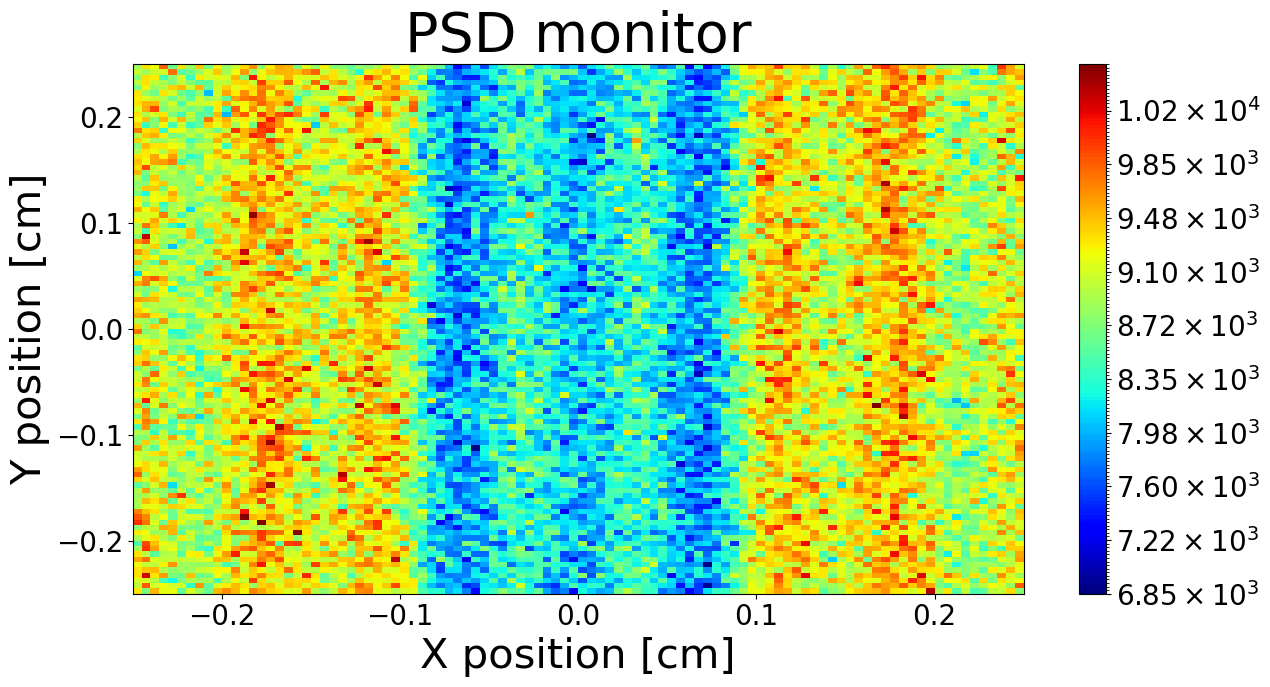


loading system configuration
INFO: Using directory: "C:\Users\xsm\Documents\GitHub\AER-HFIR-1-23\Simulations\triple_slit_vis\lc15.41"
INFO: Regenerating c-file: AER_HFIR_2023.c

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
Info:    'Source_sam' is a contributed component.
Info:    'Pol_MWP_v3' is a contributed component.
Info:    'grating_mask' is a contributed component.
CFLAGS=
INFO: Recompiling: AER_HFIR_2023.exe
AER_HFIR_2023.c: In function 'mcuse_dir':
AER_HFIR_2023.c:3629:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^
AER_HFIR_2023.c: In function 'sighandler':
AER_HFIR_2023.c:5535:64: warning: implicit declaration of function 'getpid' [-Wimplicit-function-declaration]

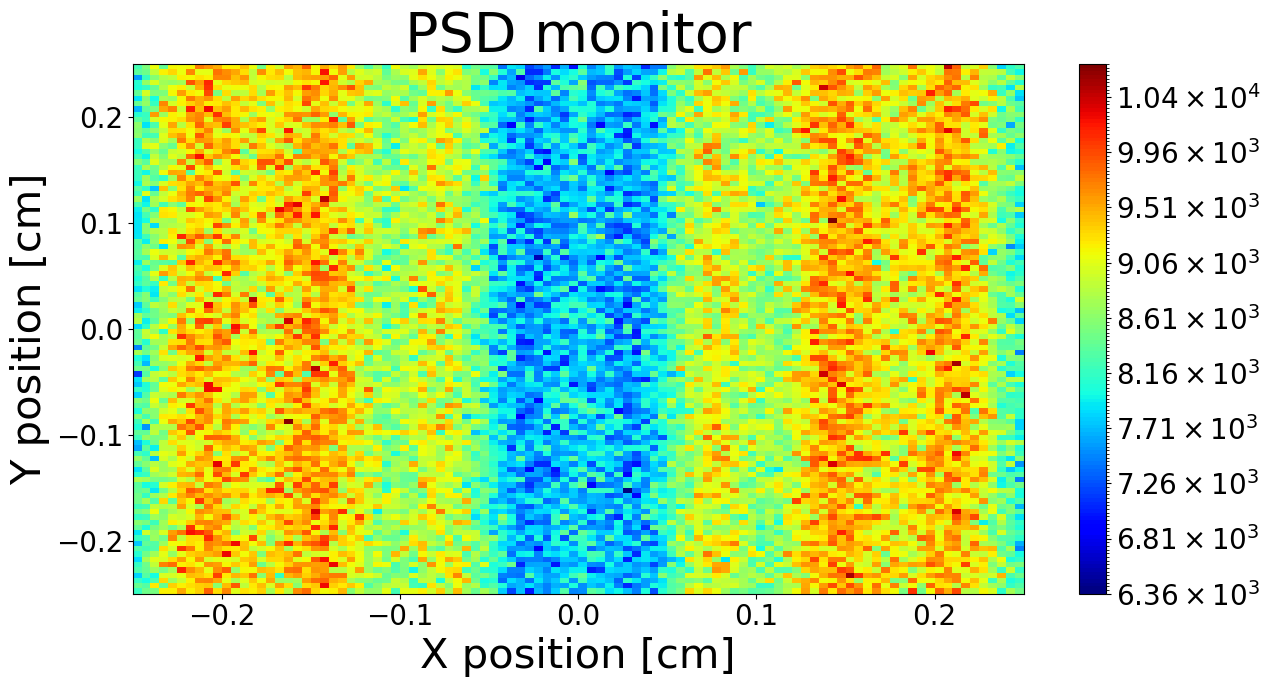


loading system configuration
INFO: Using directory: "C:\Users\xsm\Documents\GitHub\AER-HFIR-1-23\Simulations\triple_slit_vis\hc18.5"
INFO: Regenerating c-file: AER_HFIR_2023.c

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
Info:    'Source_sam' is a contributed component.
Info:    'Pol_MWP_v3' is a contributed component.
Info:    'grating_mask' is a contributed component.
CFLAGS=
INFO: Recompiling: AER_HFIR_2023.exe
AER_HFIR_2023.c: In function 'mcuse_dir':
AER_HFIR_2023.c:3629:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^
AER_HFIR_2023.c: In function 'sighandler':
AER_HFIR_2023.c:5535:64: warning: implicit declaration of function 'getpid' [-Wimplicit-function-declaration]


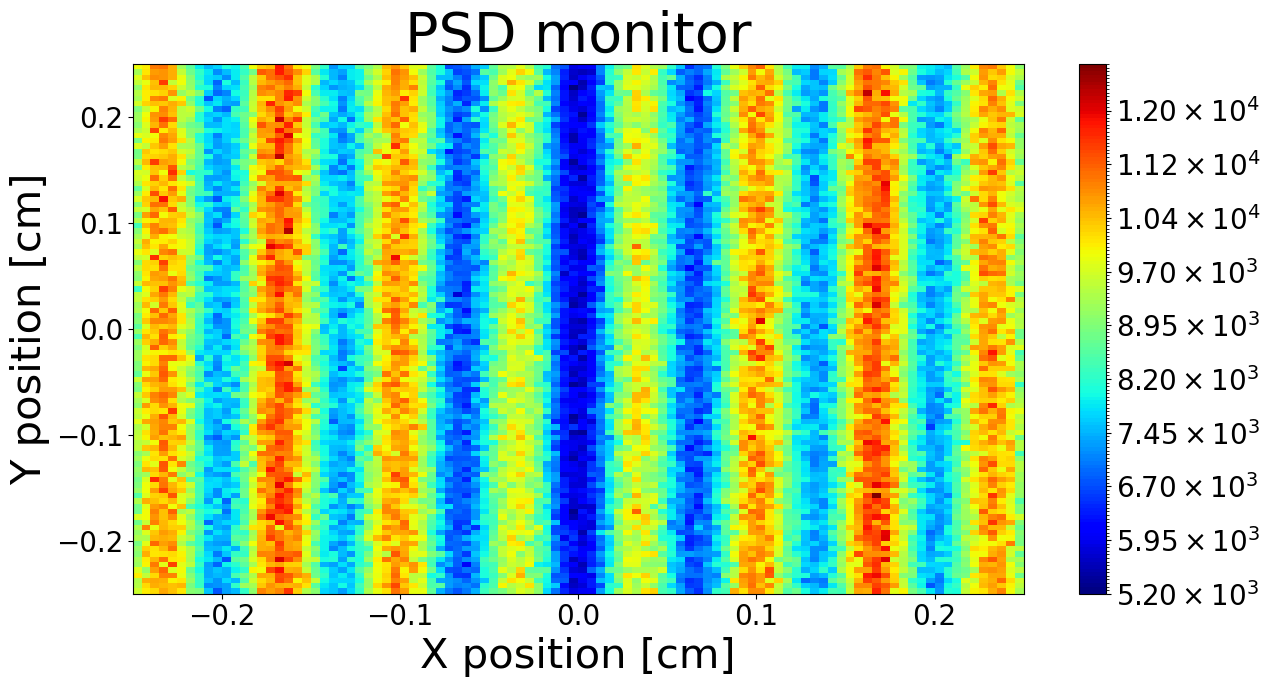


loading system configuration
INFO: Using directory: "C:\Users\xsm\Documents\GitHub\AER-HFIR-1-23\Simulations\triple_slit_vis\lc18.5"
INFO: Regenerating c-file: AER_HFIR_2023.c

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
Info:    'Source_sam' is a contributed component.
Info:    'Pol_MWP_v3' is a contributed component.
Info:    'grating_mask' is a contributed component.
CFLAGS=
INFO: Recompiling: AER_HFIR_2023.exe
AER_HFIR_2023.c: In function 'mcuse_dir':
AER_HFIR_2023.c:3629:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^
AER_HFIR_2023.c: In function 'sighandler':
AER_HFIR_2023.c:5535:64: warning: implicit declaration of function 'getpid' [-Wimplicit-function-declaration]


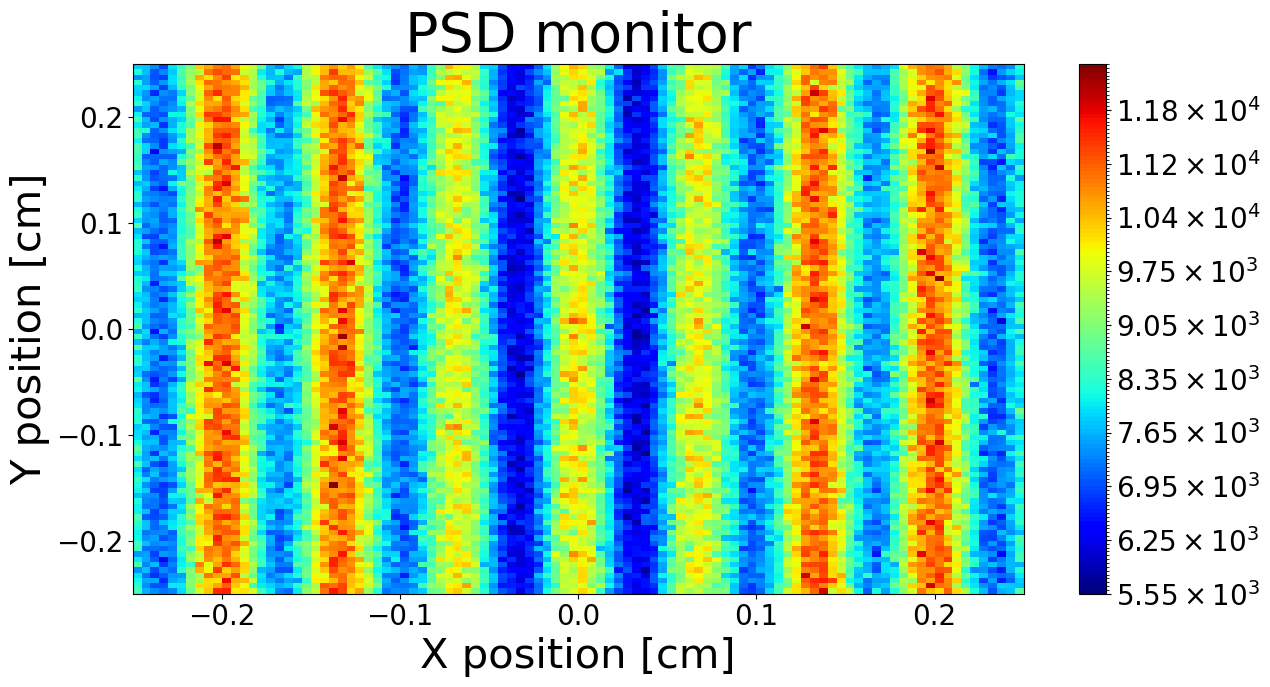


loading system configuration
INFO: Using directory: "C:\Users\xsm\Documents\GitHub\AER-HFIR-1-23\Simulations\triple_slit_vis\hc21.58"
INFO: Regenerating c-file: AER_HFIR_2023.c

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
Info:    'Source_sam' is a contributed component.
Info:    'Pol_MWP_v3' is a contributed component.
Info:    'grating_mask' is a contributed component.
CFLAGS=
INFO: Recompiling: AER_HFIR_2023.exe
AER_HFIR_2023.c: In function 'mcuse_dir':
AER_HFIR_2023.c:3629:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^
AER_HFIR_2023.c: In function 'sighandler':
AER_HFIR_2023.c:5535:64: warning: implicit declaration of function 'getpid' [-Wimplicit-function-declaration]

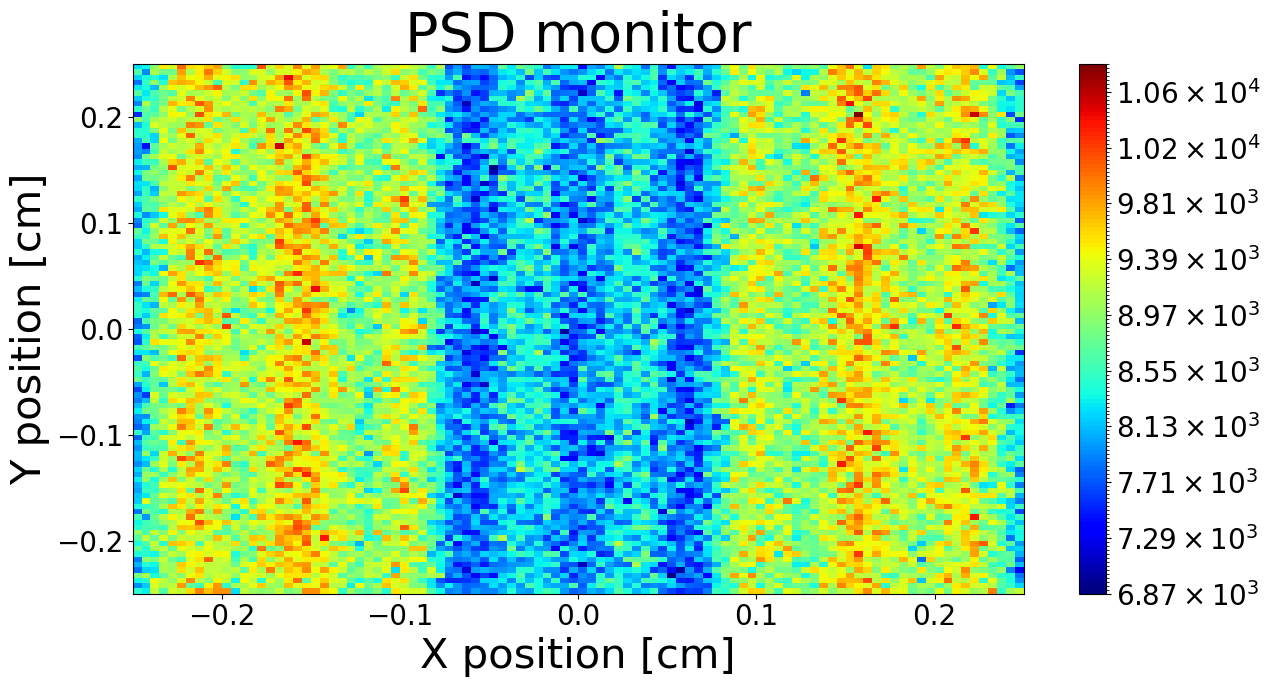


loading system configuration
INFO: Using directory: "C:\Users\xsm\Documents\GitHub\AER-HFIR-1-23\Simulations\triple_slit_vis\lc21.58"
INFO: Regenerating c-file: AER_HFIR_2023.c

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
Info:    'Source_sam' is a contributed component.
Info:    'Pol_MWP_v3' is a contributed component.
Info:    'grating_mask' is a contributed component.
CFLAGS=
INFO: Recompiling: AER_HFIR_2023.exe
AER_HFIR_2023.c: In function 'mcuse_dir':
AER_HFIR_2023.c:3629:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^
AER_HFIR_2023.c: In function 'sighandler':
AER_HFIR_2023.c:5535:64: warning: implicit declaration of function 'getpid' [-Wimplicit-function-declaration]

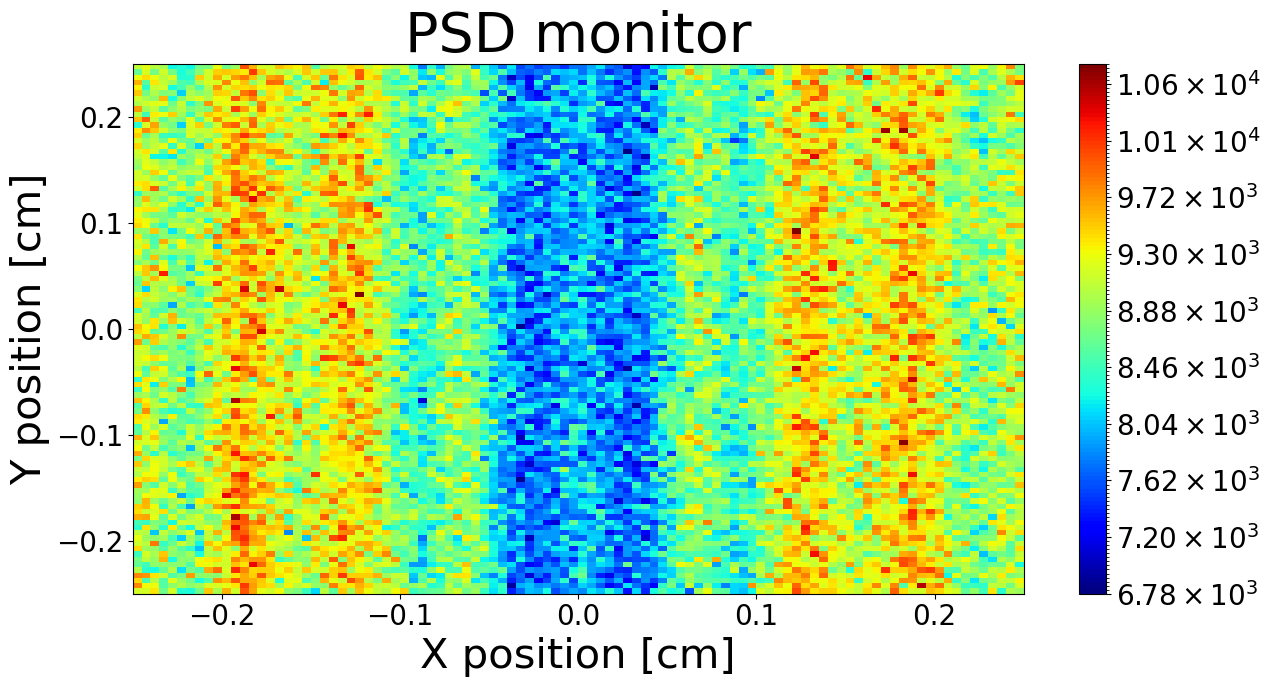


loading system configuration
INFO: Using directory: "C:\Users\xsm\Documents\GitHub\AER-HFIR-1-23\Simulations\triple_slit_vis\hc24.66"
INFO: Regenerating c-file: AER_HFIR_2023.c

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
Info:    'Source_sam' is a contributed component.
Info:    'Pol_MWP_v3' is a contributed component.
Info:    'grating_mask' is a contributed component.
CFLAGS=
INFO: Recompiling: AER_HFIR_2023.exe
AER_HFIR_2023.c: In function 'mcuse_dir':
AER_HFIR_2023.c:3629:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^
AER_HFIR_2023.c: In function 'sighandler':
AER_HFIR_2023.c:5535:64: warning: implicit declaration of function 'getpid' [-Wimplicit-function-declaration]

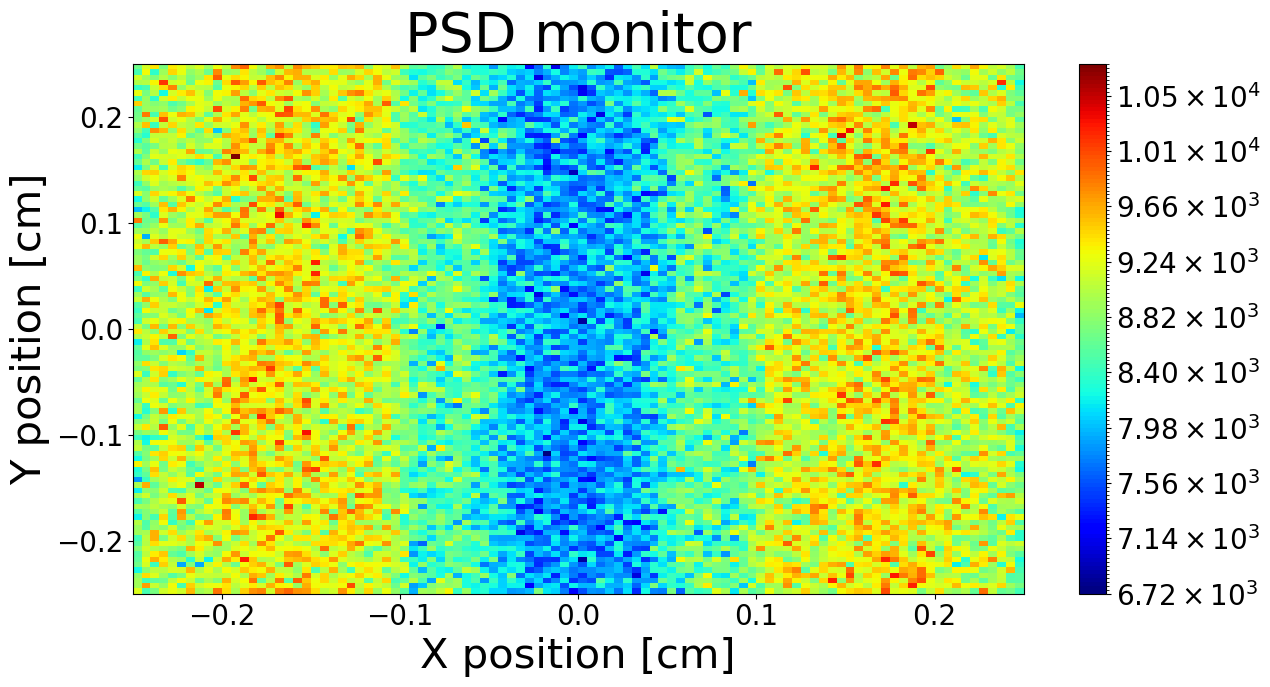


loading system configuration
INFO: Using directory: "C:\Users\xsm\Documents\GitHub\AER-HFIR-1-23\Simulations\triple_slit_vis\lc24.66"
INFO: Regenerating c-file: AER_HFIR_2023.c

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
Info:    'Source_sam' is a contributed component.
Info:    'Pol_MWP_v3' is a contributed component.
Info:    'grating_mask' is a contributed component.
CFLAGS=
INFO: Recompiling: AER_HFIR_2023.exe
AER_HFIR_2023.c: In function 'mcuse_dir':
AER_HFIR_2023.c:3629:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^
AER_HFIR_2023.c: In function 'sighandler':
AER_HFIR_2023.c:5535:64: warning: implicit declaration of function 'getpid' [-Wimplicit-function-declaration]

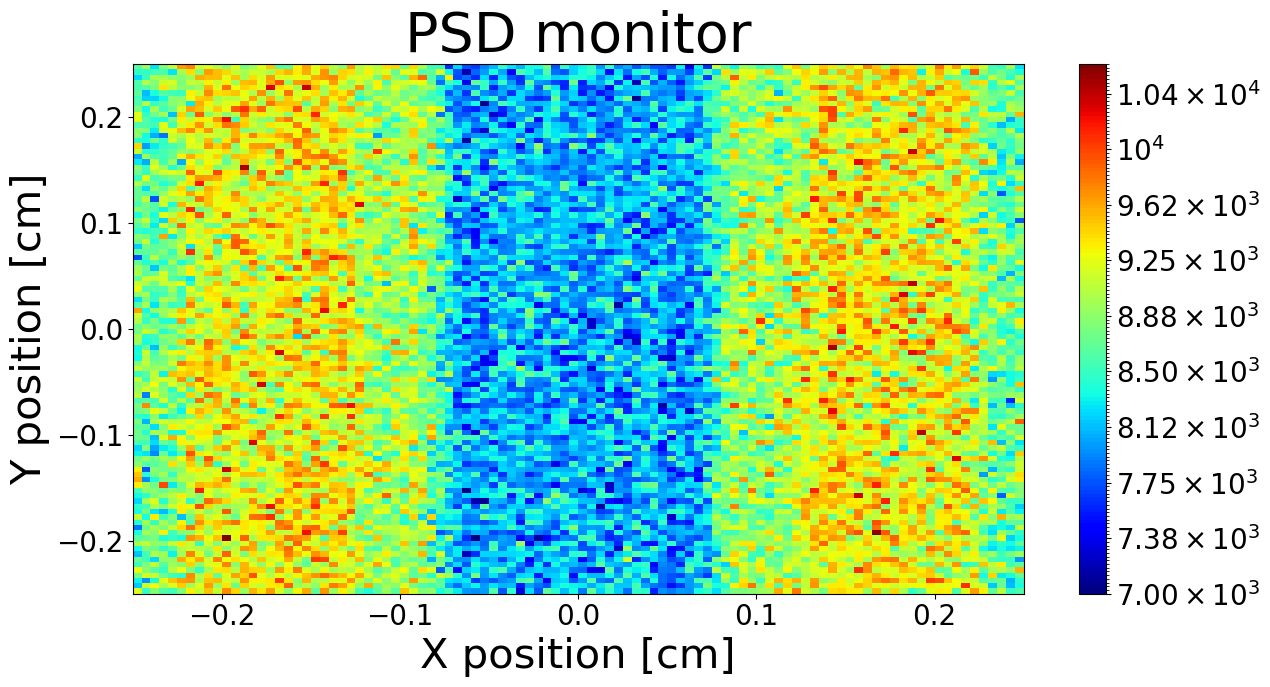


loading system configuration
INFO: Using directory: "C:\Users\xsm\Documents\GitHub\AER-HFIR-1-23\Simulations\triple_slit_vis\hc27.75"
INFO: Regenerating c-file: AER_HFIR_2023.c

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
Info:    'Source_sam' is a contributed component.
Info:    'Pol_MWP_v3' is a contributed component.
Info:    'grating_mask' is a contributed component.
CFLAGS=
INFO: Recompiling: AER_HFIR_2023.exe
AER_HFIR_2023.c: In function 'mcuse_dir':
AER_HFIR_2023.c:3629:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^
AER_HFIR_2023.c: In function 'sighandler':
AER_HFIR_2023.c:5535:64: warning: implicit declaration of function 'getpid' [-Wimplicit-function-declaration]

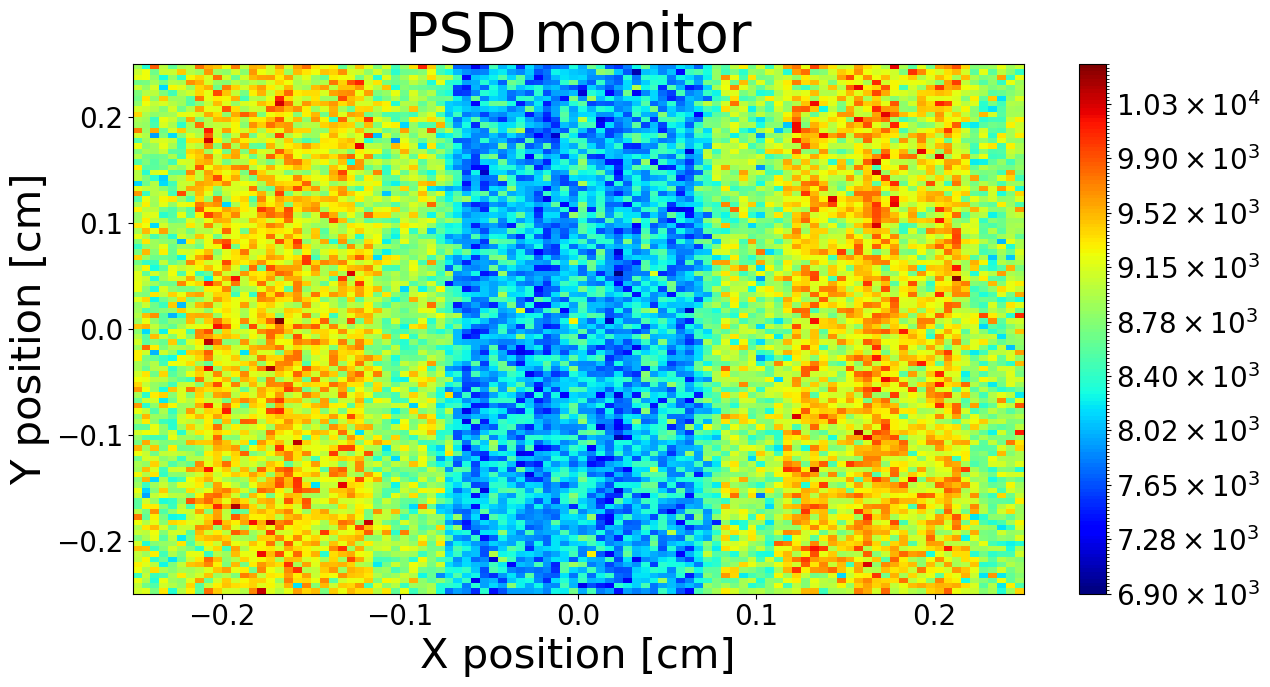


loading system configuration
INFO: Using directory: "C:\Users\xsm\Documents\GitHub\AER-HFIR-1-23\Simulations\triple_slit_vis\lc27.75"
INFO: Regenerating c-file: AER_HFIR_2023.c

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
Info:    'Source_sam' is a contributed component.
Info:    'Pol_MWP_v3' is a contributed component.
Info:    'grating_mask' is a contributed component.
CFLAGS=
INFO: Recompiling: AER_HFIR_2023.exe
AER_HFIR_2023.c: In function 'mcuse_dir':
AER_HFIR_2023.c:3629:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^
AER_HFIR_2023.c: In function 'sighandler':
AER_HFIR_2023.c:5535:64: warning: implicit declaration of function 'getpid' [-Wimplicit-function-declaration]

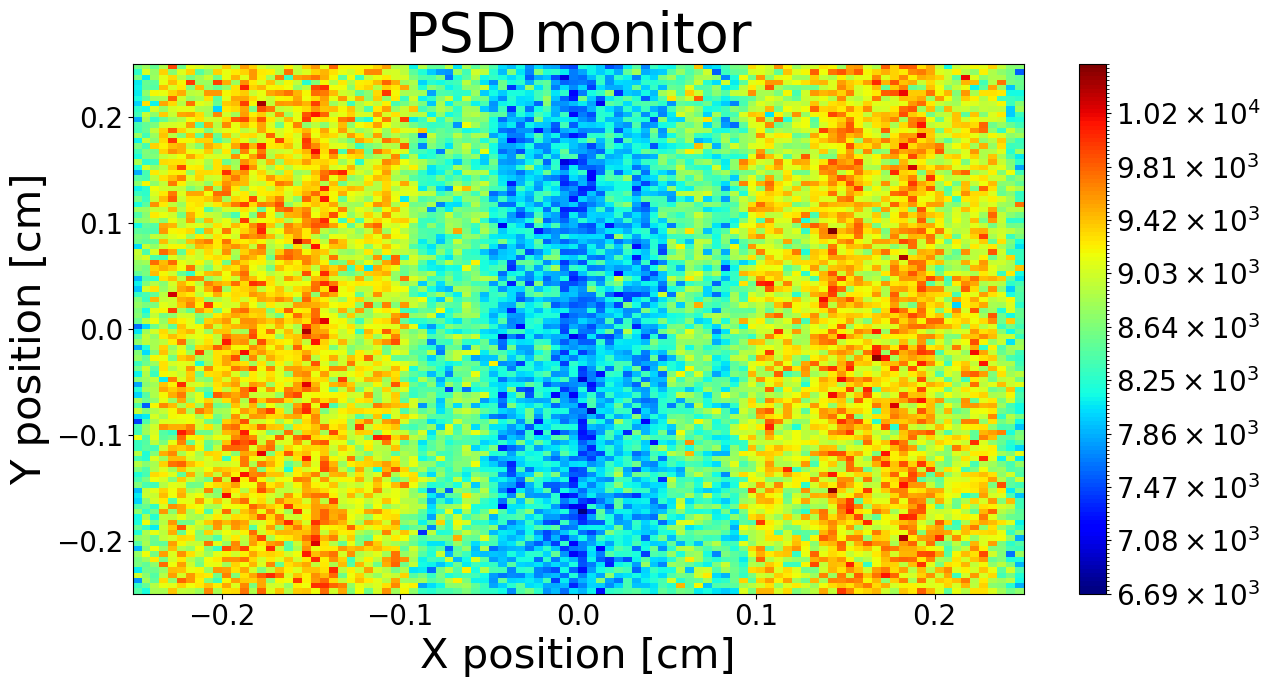


loading system configuration
INFO: Using directory: "C:\Users\xsm\Documents\GitHub\AER-HFIR-1-23\Simulations\triple_slit_vis\hc30.83"
INFO: Regenerating c-file: AER_HFIR_2023.c

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
Info:    'Source_sam' is a contributed component.
Info:    'Pol_MWP_v3' is a contributed component.
Info:    'grating_mask' is a contributed component.
CFLAGS=
INFO: Recompiling: AER_HFIR_2023.exe
AER_HFIR_2023.c: In function 'mcuse_dir':
AER_HFIR_2023.c:3629:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^
AER_HFIR_2023.c: In function 'sighandler':
AER_HFIR_2023.c:5535:64: warning: implicit declaration of function 'getpid' [-Wimplicit-function-declaration]

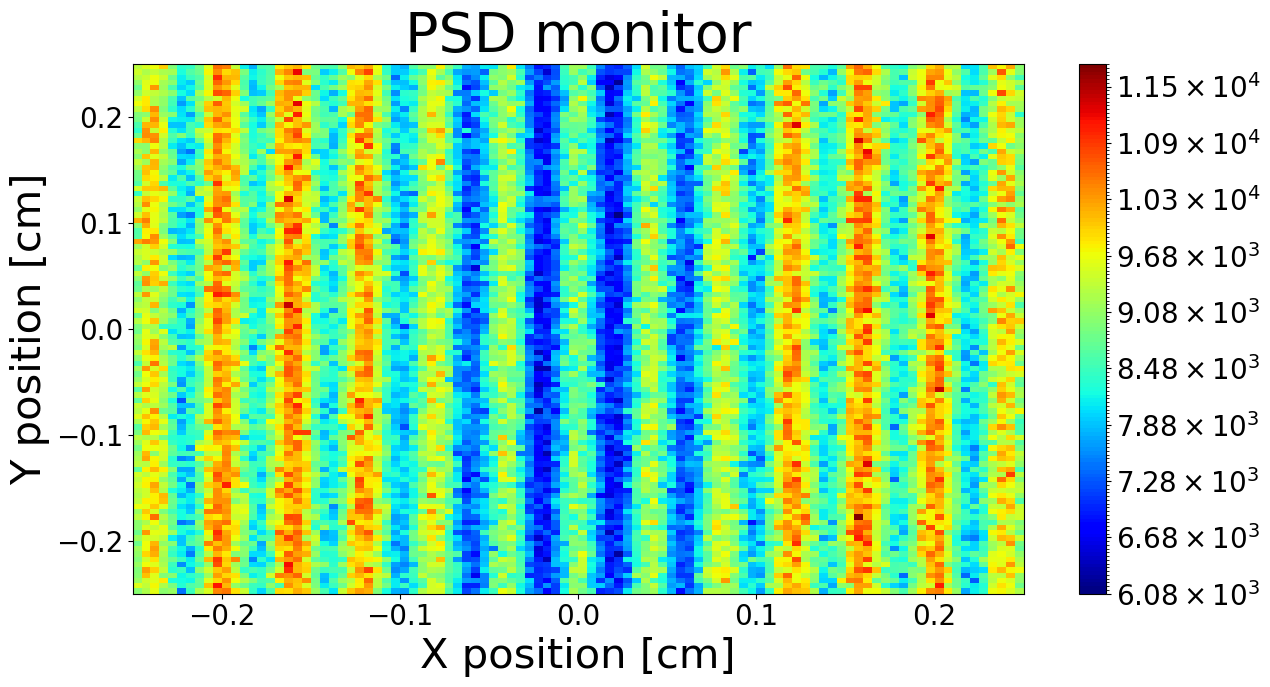


loading system configuration
INFO: Using directory: "C:\Users\xsm\Documents\GitHub\AER-HFIR-1-23\Simulations\triple_slit_vis\lc30.83"
INFO: Regenerating c-file: AER_HFIR_2023.c

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
Info:    'Source_sam' is a contributed component.
Info:    'Pol_MWP_v3' is a contributed component.
Info:    'grating_mask' is a contributed component.
CFLAGS=
INFO: Recompiling: AER_HFIR_2023.exe
AER_HFIR_2023.c: In function 'mcuse_dir':
AER_HFIR_2023.c:3629:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^
AER_HFIR_2023.c: In function 'sighandler':
AER_HFIR_2023.c:5535:64: warning: implicit declaration of function 'getpid' [-Wimplicit-function-declaration]

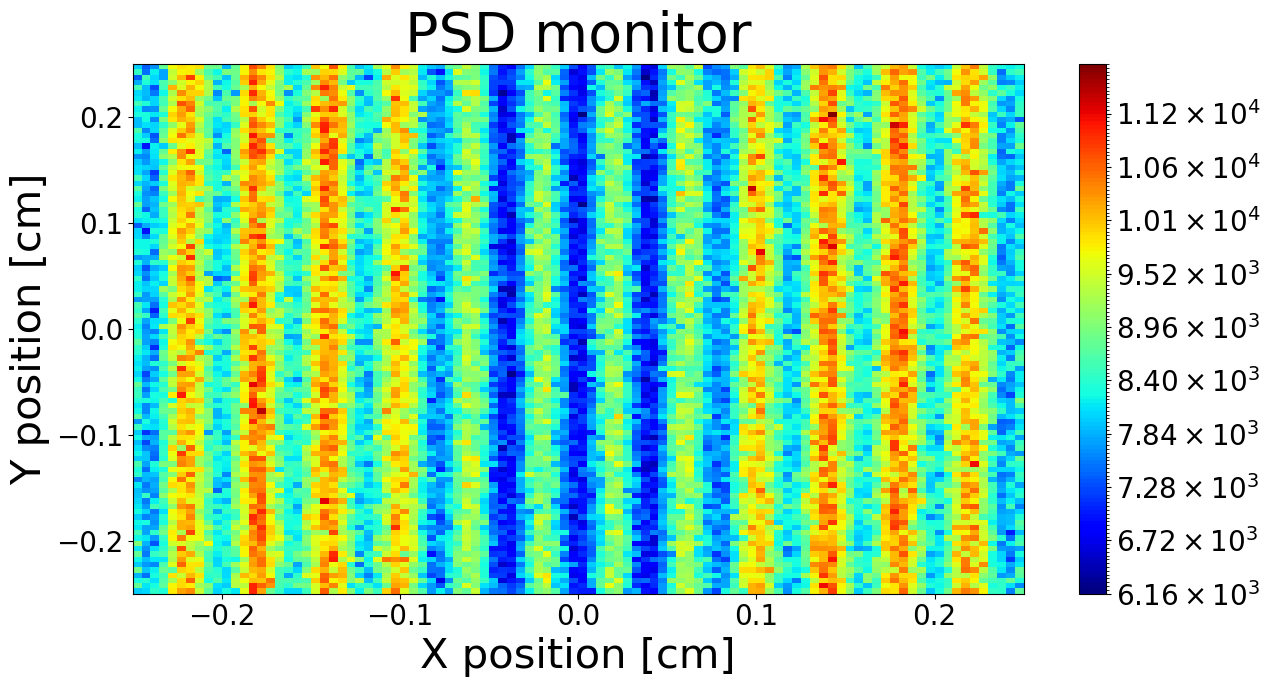

Sim time: 13.315 minutes.


In [7]:
RAY_NUM=2e7 #global control of neutron rays

path = 'Simulations\\triple_slit_vis\\'

def do_run(ray_num,current,sample_in=True,pols=True,plot=True):
    """Performs McStas simulation of high and low count spin state.
    Returns high and low count intensities."""
    AER.settings(output_path=f'{path}hc{round(current,2)}',ncount=ray_num)
    low_count.value, all_off.value, cur1.value, cur2.value = 0, 0, current, -current
    AER_hc = AER.backengine()
    if plot: ms.make_sub_plot(AER_hc)
    if pols==False or int(current*10)==0: return AER_hc[0].Intensity #ignores low counts
    else:
        AER.settings(output_path=f'{path}lc{round(current,2)}',ncount=ray_num)
        low_count.value, all_off.value, cur1.value, cur2.value = 1, 0, current, -current
        AER_lc = AER.backengine()
        if plot: ms.make_sub_plot(AER_lc)
        return AER_hc[0].Intensity, AER_lc[0].Intensity

def do_scan(ray_num,cur,sample_in=True,pols=True):
    """Performs current scan for given number of AER harmonics.
    Returns lists of intensities and erros from do_run."""
    results = [[] for c in cur]
    if sample_in==False: pass#source.sam([1,1,dists['sam']])
    for indx,c in enumerate(cur):
        results[indx] = do_run(ray_num,c,sample_in=sample_in,pols=pols)
    return results

time_start = time.time()
cur_scan = do_scan(RAY_NUM,currents)
time_end = time.time()
print(f'Sim time: {round((time_end-time_start)/60,3)} minutes.')

***
### Extracts polarizations from data
***

Currents used: [ 0.    3.08  6.17  9.25 12.33 15.41 18.5  21.58 24.66 27.75 30.83] 



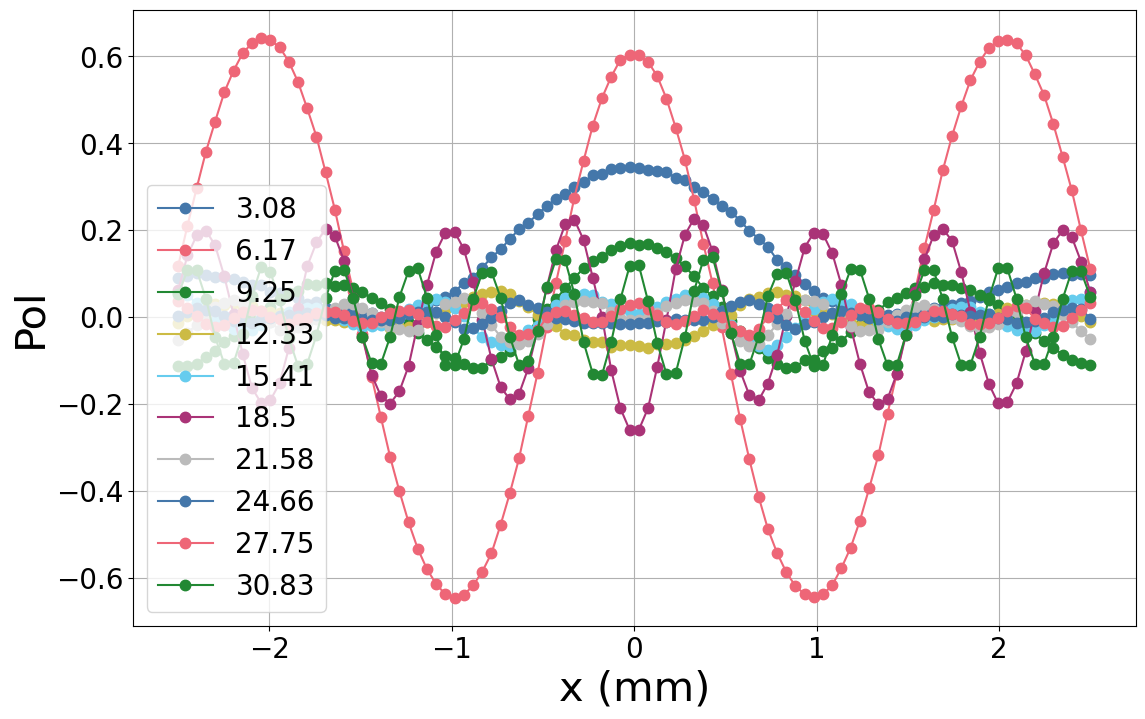

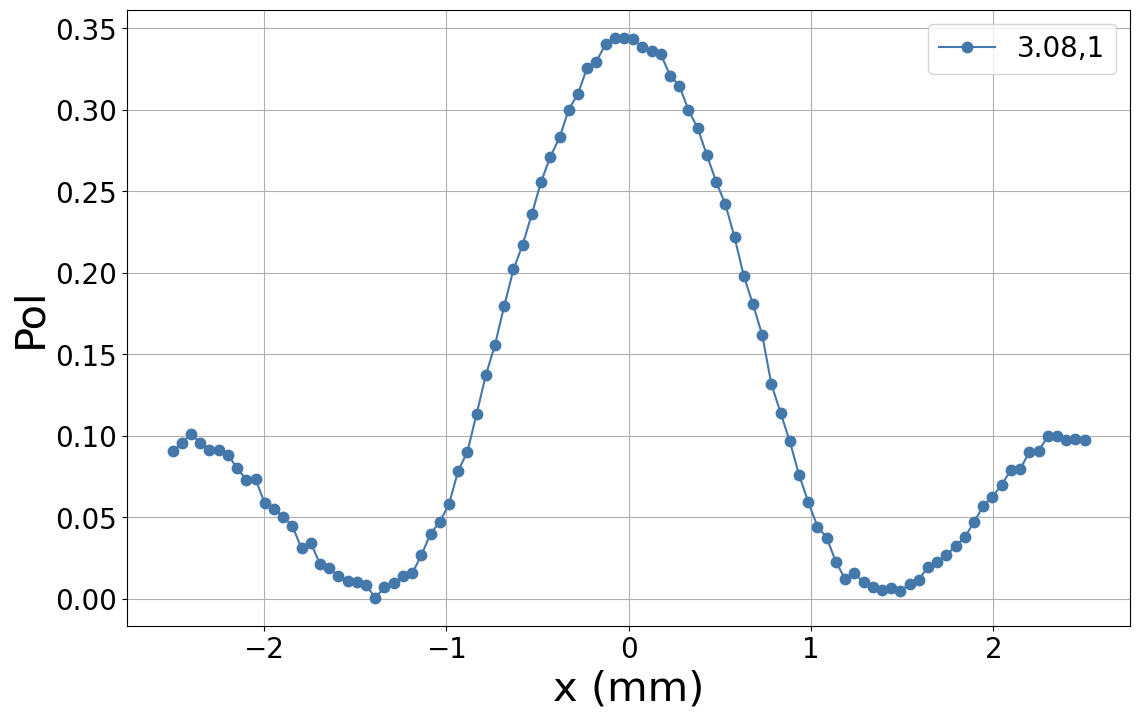

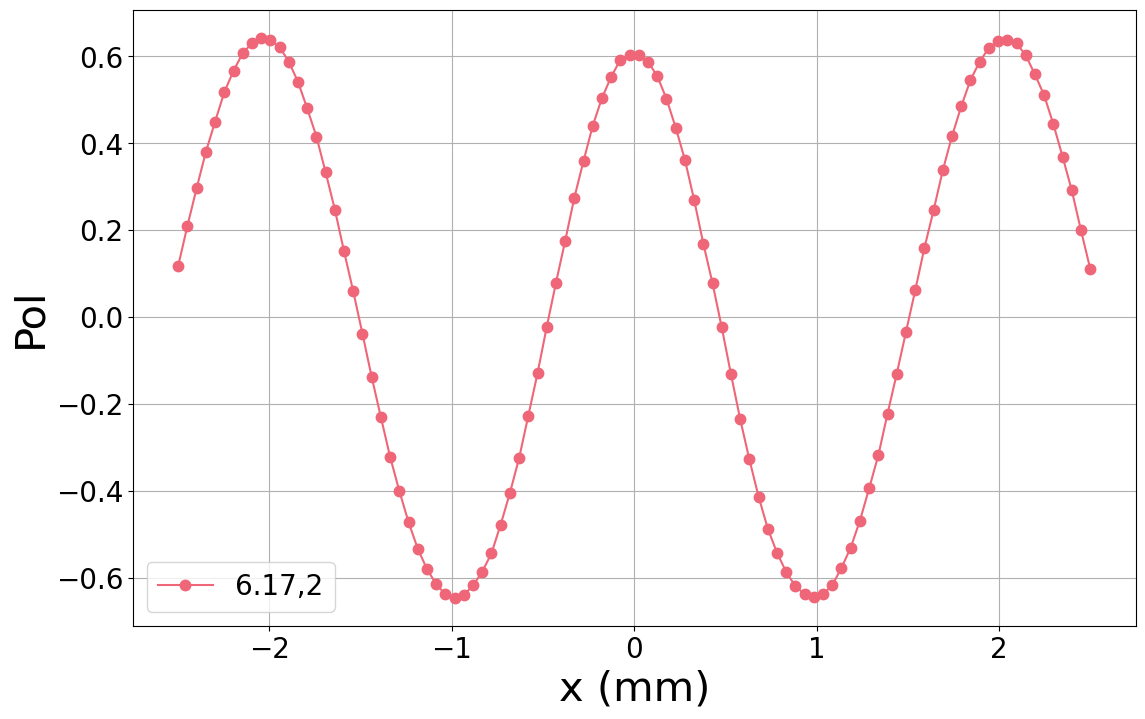

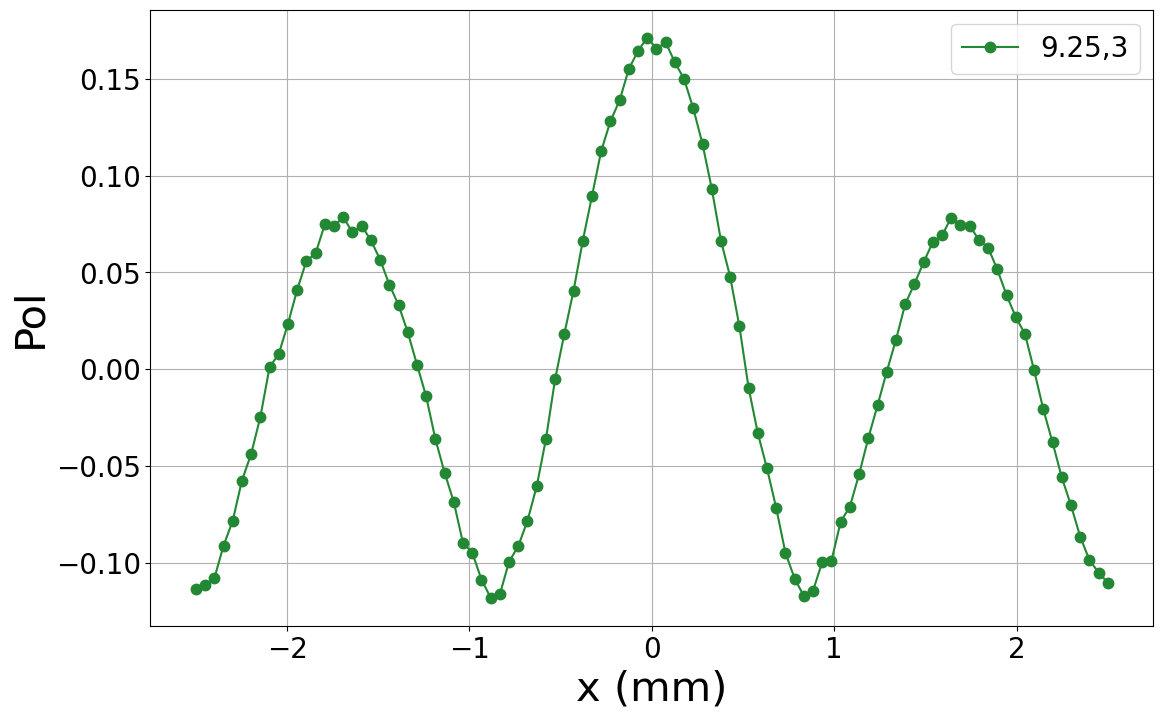

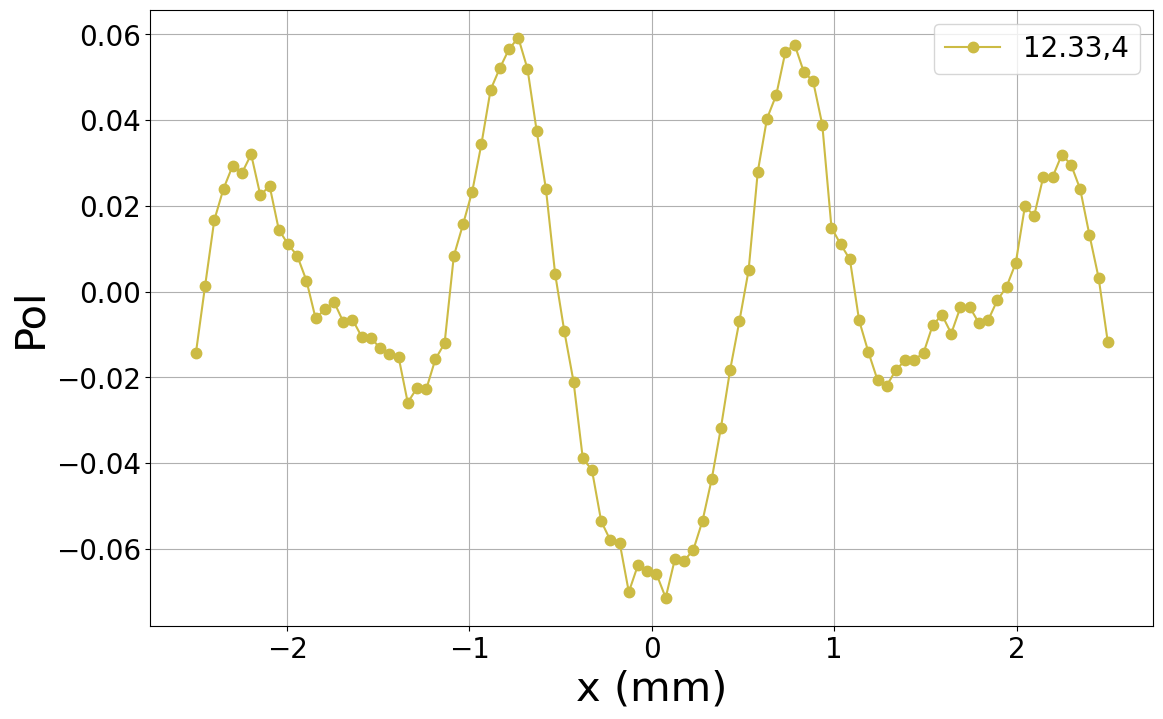

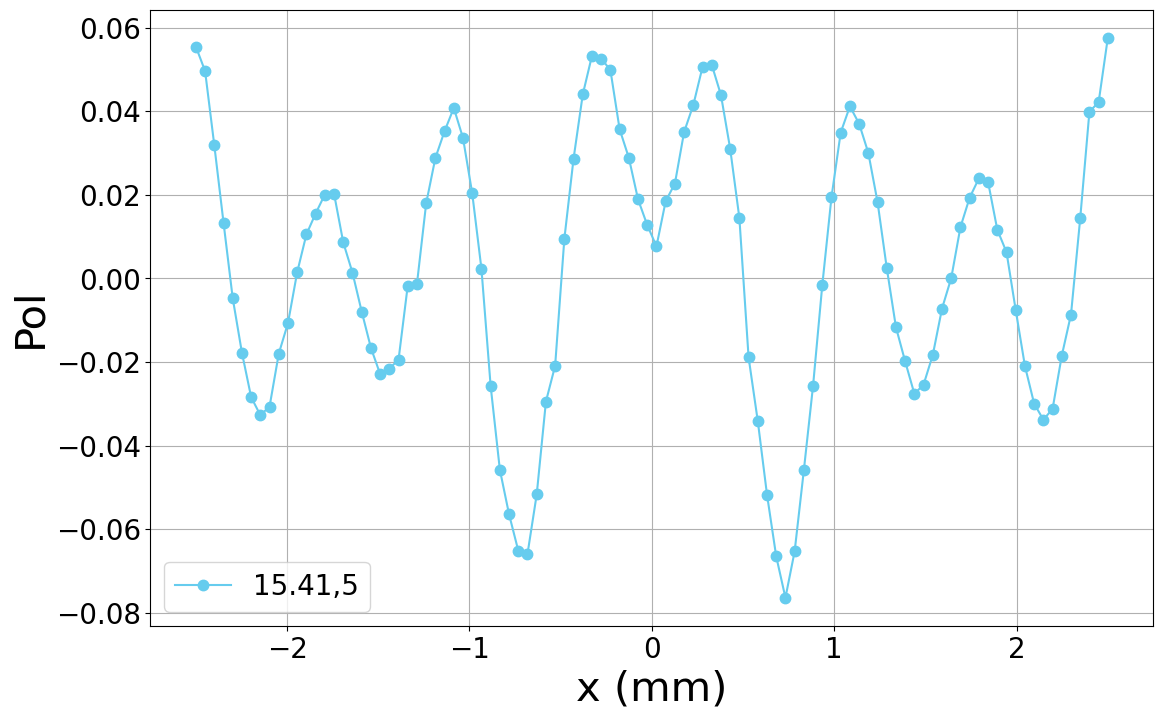

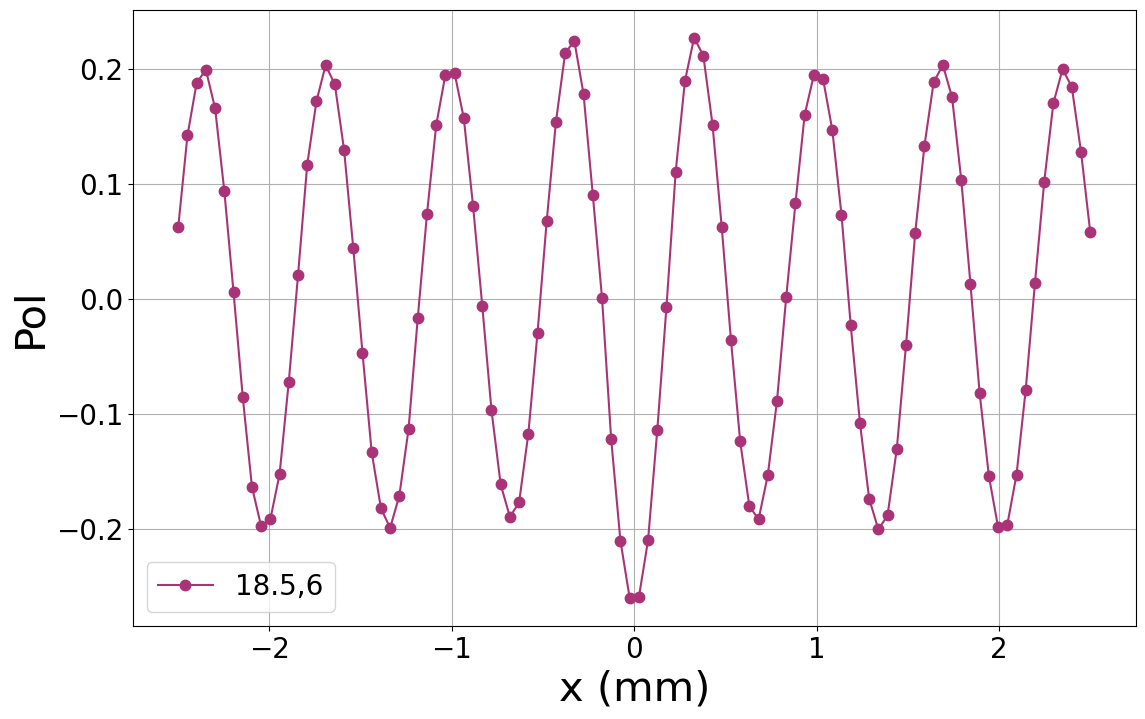

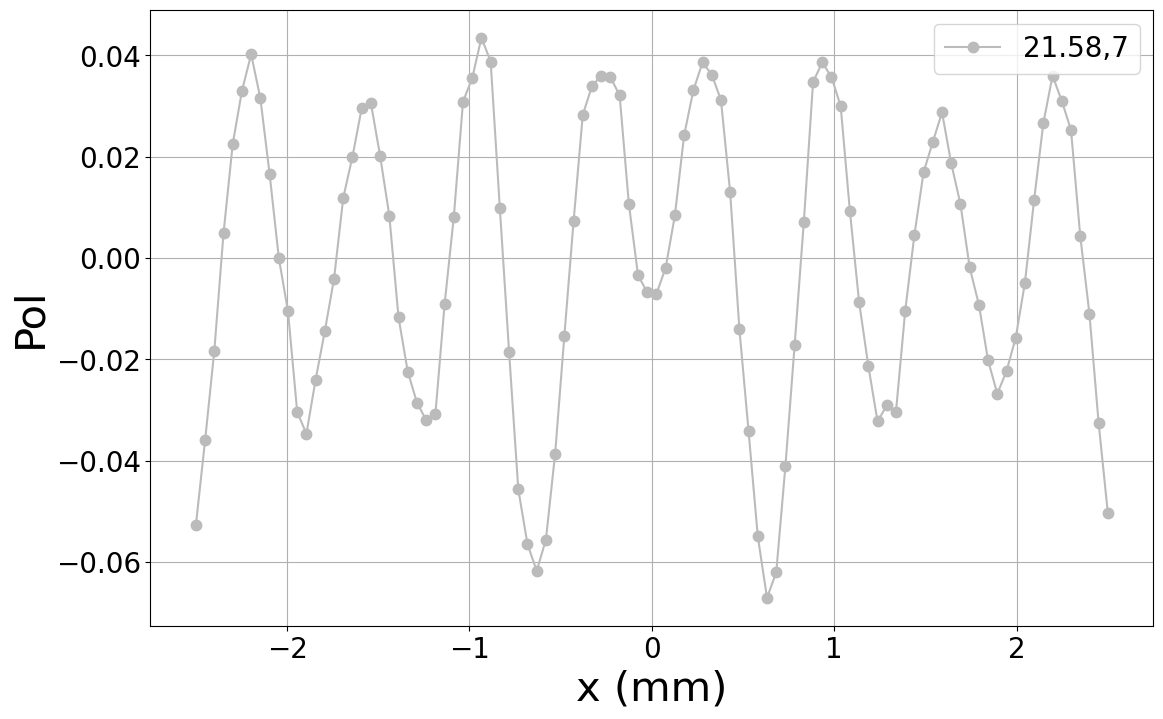

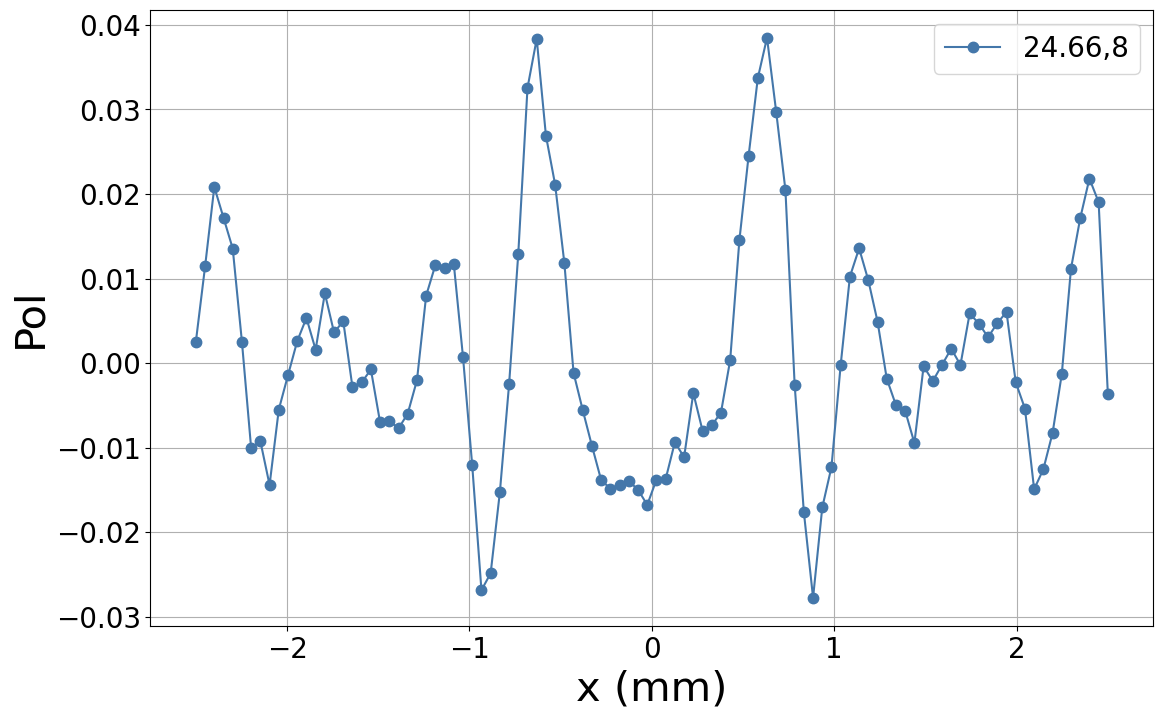

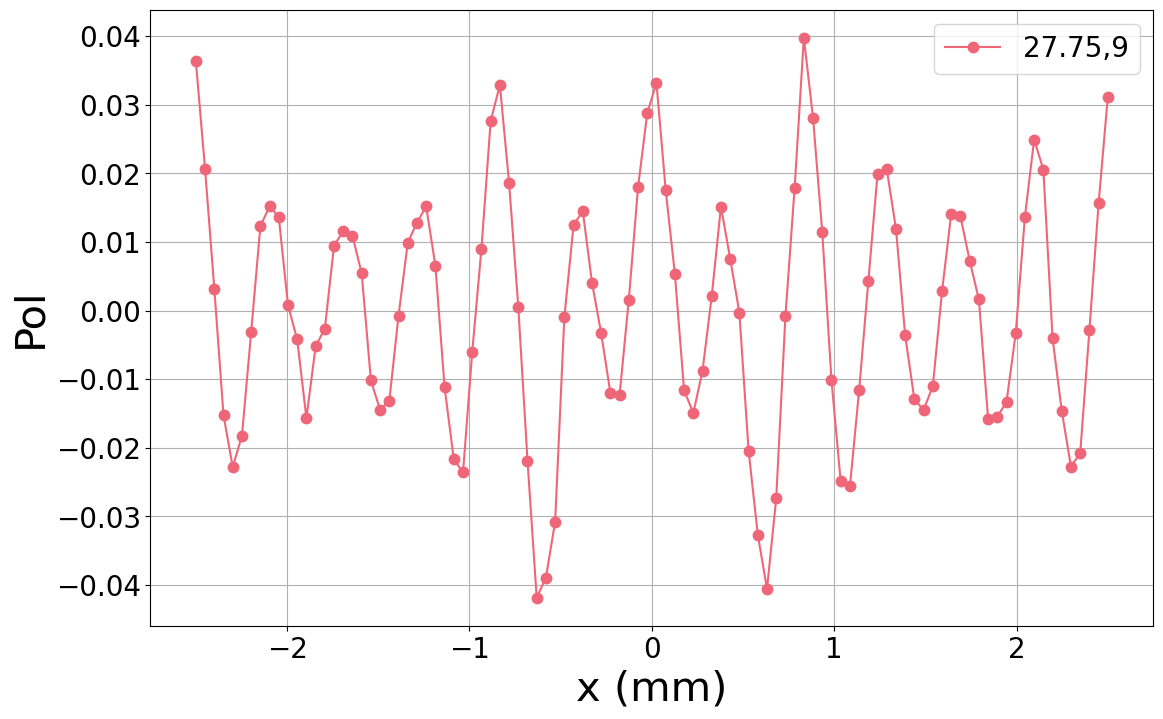

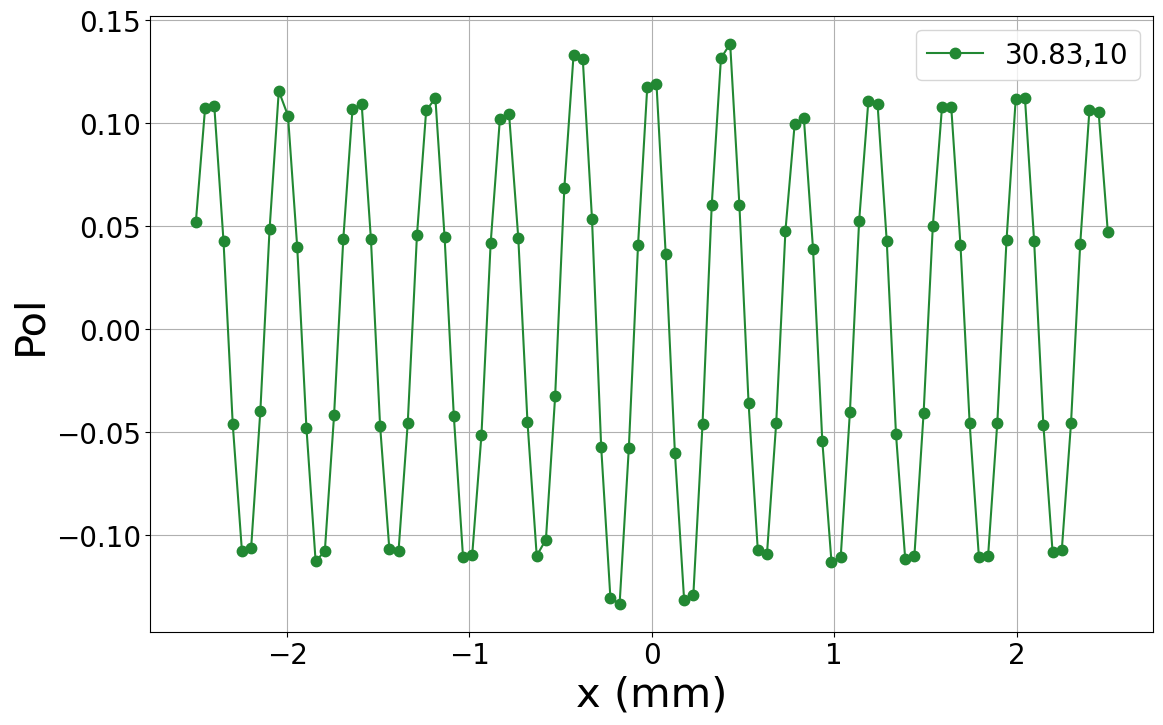

In [8]:
def rebin(data,new_shape):
    """Rebins 2D data by taking average."""
    sh = new_shape[0],data.shape[0]//new_shape[0],new_shape[1],data.shape[1]//new_shape[1]
    return data.reshape(sh).mean(3).mean(1)

def get_pol(data):
    """Returns 2D polarization from current scans."""
    pol = np.zeros(np.shape(data[0]))
    for indx,val in np.ndenumerate(pol):
        sum = data[0,indx[0],indx[1]] + data[1,indx[0],indx[1]]
        if sum != 0:
            pol[indx[0],indx[1]] = (data[0,indx[0],indx[1]] - data[1,indx[0],indx[1]])/sum
    return pol

pols = [get_pol(np.array(cur_scan[1:][i])) for i in range(0,len(cur_scan)-1)] #removing constant scan
print(f'Currents used: {np.round(currents,2)} \n')

plot_pols,plot_slices,plot_all_slices,do_rebin = False,True,True,False
rebin_size = (50,50)
if do_rebin: print(f'New bin size: {round(det_x/rebin_size[0],3)} (mm)')

if plot_pols:
    for indx,p in enumerate(pols):
        fig = plt.figure(figsize=(plot_width,plot_height))
        plt.title(f'Harm. {indx+1}, {round(currents[indx+1],2)} amps')
        plt.tight_layout()
        if do_rebin: p=rebin(p,rebin_size)
        plt.imshow(p,origin='lower',extent=[-det_x/2,det_x/2,-det_y/2,det_y/2],interpolation='none')
        plt.ylabel('y (mm)')
        plt.xlabel('x (mm)')
        plt.colorbar()
        plt.show()

if plot_all_slices:
    fig = plt.figure(figsize=(plot_width,plot_height))
    x = np.linspace(-det_x/2,det_x/2,bin_x)
    for indx,p in enumerate(pols):
        if do_rebin:
            p = rebin(p,rebin_size)
            x = np.linspace(-det_x/2,det_x/2,rebin_size[0])
        plt.plot(x,np.mean(p,axis=0),'.-',ms=15,label=f'{round(currents[indx+1],2)}')
    plt.ylabel('Pol')
    plt.xlabel('x (mm)')
    plt.legend()
    plt.show()
    
if plot_slices:
    x = np.linspace(-det_x/2,det_x/2,bin_x)
    for indx,p in enumerate(pols):
        fig = plt.figure(figsize=(plot_width,plot_height))
        if do_rebin:
            p = rebin(p,rebin_size)
            x = np.linspace(-det_x/2,det_x/2,rebin_size[0])
        plt.plot(x,np.mean(p,axis=0),'.-',ms=15,label=f'{round(currents[indx+1],2)},{indx+1}',color=f'C{indx}')
        plt.ylabel('Pol')
        plt.xlabel('x (mm)')
        plt.legend()
        plt.show()

***
## Simulated polarization analysis
***

Simulated Fourier coefficients:
	 a1 = 0.34394, b1 = -0.00178
	 a2 = 0.60686, b2 = -0.00497
	 a3 = 0.17015, b3 = 0.02391
	 a4 = -0.06747, b4 = -0.00358
	 a5 = 0.01212, b5 = -0.00991
	 a6 = -0.25971, b6 = -0.00364
	 a7 = -0.00851, b7 = -0.01482
	 a8 = -0.01466, b8 = 0.01243
	 a9 = 0.02808, b9 = 0.00619
	 a10 = 0.09722, b10 = -0.00185
Analytic Fourier coefficients:
	 a1 = 0.00717, b1 = 0.0
	 a2 = 0.63984, b2 = 0.0
	 a3 = -0.00705, b3 = 0.0
	 a4 = 0.00504, b4 = 0.0
	 a5 = -0.00727, b5 = -0.0
	 a6 = -0.21333, b6 = -0.0
	 a7 = 0.00699, b7 = -0.0
	 a8 = -0.00511, b8 = 0.0
	 a9 = 0.00748, b9 = 0.0
	 a10 = 0.12792, b10 = 0.0


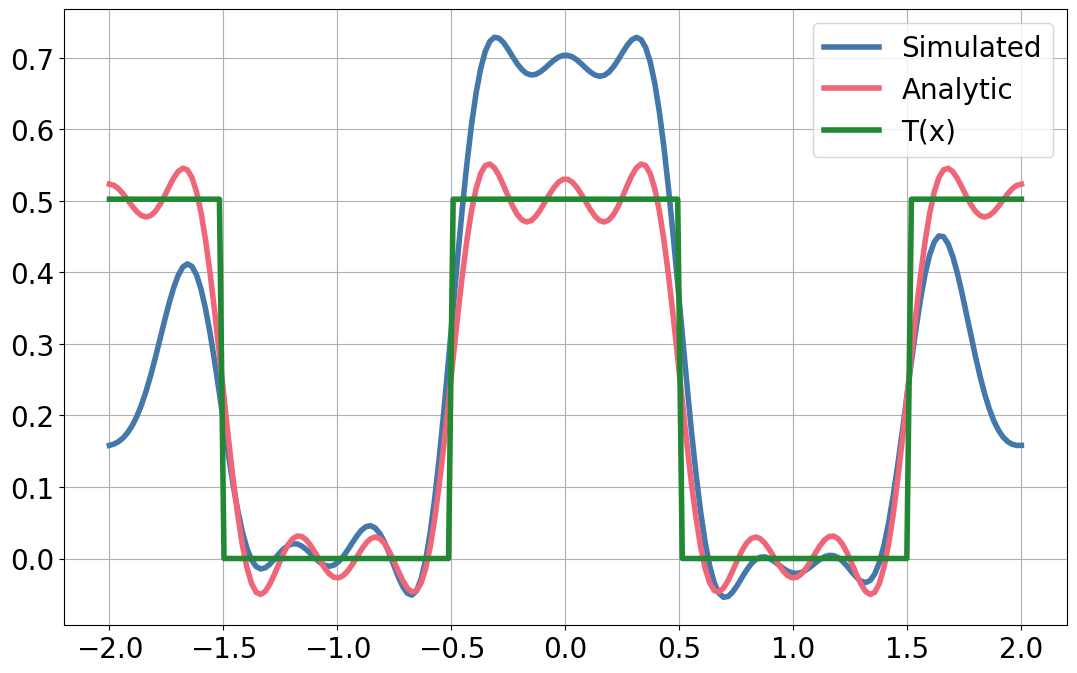

In [215]:
x = np.linspace(-det_x/2,det_x/2,bin_x)
x_mid = x[len(p)//2-4:len(p)//2+4]
x_fine = np.linspace(-det_x/2,det_x/2,200)
fits,errs,guess = [[] for i in range(len(pols))],[[] for i in range(len(pols))],[[] for i in range(len(pols))]
peak_fits,peak_errs,peak_guess = [[] for i in range(len(pols))],[[] for i in range(len(pols))],[[] for i in range(len(pols))]

def fit_pols(pols,plot_fits=True,plot_peaks=True):
    for i,_ in enumerate(pols):
        p = np.mean(pols[i],axis=0)
        guess[i] = np.array([p[len(p)//2],.0,2*np.pi*(i + 1)/res])
        #guess[i] = np.array([p[len(p)//2],2*np.pi*(i + 2)/res,0])
        peak_guess[i] = [-1.,0,p[len(p)//2]]
        p_mid = p[len(p)//2-4:len(p)//2+4]
        fits[i],errs[i] = curve_fit(pol_sc,x,p,p0=guess[i])
        peak_fits[i],peak_errs[i] = curve_fit(quad,x_mid,p_mid,p0=guess[i])
        
        if plot_fits:
            fig = plt.figure(figsize=(plot_width,plot_height))
            plt.title(f'Harm. {i+1}, {round(currents[i+1],2)} amps')
            plt.plot(x,np.mean(pols[i],axis=0),'.',color='C0')
            plt.plot(x,pol_sc(x,*fits[i]),color='C0',label='Fit')
            plt.plot(x,pol_sc(x,*guess[i]),color='C1',label='Guess')
            plt.legend()
            plt.show()
        if plot_peaks:
            fig = plt.figure(figsize=(plot_width,plot_height))
            plt.title(f'Harm. {i+1}, {round(currents[i+1],2)} amps')
            plt.plot(x,np.mean(pols[i],axis=0),'.',color='C0')
            plt.plot(x_mid,quad(x_mid,*peak_fits[i]),color='C0',label='Quad Fit')
            print(f'Const={round(peak_fits[i][2],2)}, Lin={round(peak_fits[i][1],2)}')
            plt.legend()
            plt.show()

def sum_series(x,R,an,bn,a0=1,norm=True):
    """Sums Fourier series from coefficients."""
    assert(len(an) == len(bn)), "Too many an's or bn's!"
    cn = np.array([np.cos(2*np.pi*(i+1)*x/R) for i in range(len(an))])
    sn = np.array([np.sin(2*np.pi*(i+1)*x/R) for i in range(len(an))])
    tot = a0 + 2*(np.dot(an,cn) + np.dot(bn,sn))
    if norm: tot = tot/simpson(tot,x)
    return tot

def get_coeff(x,f,n,R,print_coeff=True):
    """Returns Fourier cosine or sine coefficient."""
    an = simpson(f*np.cos(2*np.pi*n/R*x),x)
    bn = simpson(f*np.sin(2*np.pi*n/R*x),x)
    if print_coeff: print(f'\t a{n} = {round(an,5)}, b{n} = {round(bn,5)}')
    return an,bn

def get_ana(x,f,n,R,a0=1,norm=True,print_coeff=True):
    """Returns Fourier series up to order n. a0 is given"""
    an,bn = np.zeros(n),np.zeros(n)
    if print_coeff: print(f'Analytic Fourier coefficients:')
    for n in range(n):
        an[n],bn[n] = get_coeff(x,f,n+1,R,print_coeff)
    return sum_series(x,R,an,bn,a0=a0,norm=norm)

fit_pols(pols,plot_fits=False,plot_peaks=False)
peak_fits = np.array(peak_fits)
print('Simulated Fourier coefficients:')
for n in range(len(peak_fits[:,2])):
    print(f'\t a{n+1} = {round(peak_fits[n,2],5)}, b{n+1} = {round(peak_fits[n,1],5)}')

res_fine = np.linspace(-res/2,res/2,200)

image = sum_series(res_fine,res,peak_fits[:,2],peak_fits[:,1])

coarse_mask = grating(res_fine,1,1,3,-.5)  #magic number for offset
coarse_mask = coarse_mask/simpson(coarse_mask,res_fine)
ana = get_ana(res_fine,coarse_mask,10,res)

fig = plt.figure(figsize=(plot_width,plot_height))
plt.plot(res_fine,image,linewidth=4,label='Simulated')
plt.plot(res_fine,ana,linewidth=4,label='Analytic')
plt.plot(res_fine,coarse_mask,linewidth=4,label='T(x)')
plt.legend()
plt.show()

Fourier coefficients:
	 a1 = 1e-05, b1 = -0.0
	 a2 = -1e-05, b2 = -0.0
	 a3 = 1e-05, b3 = -0.0
	 a4 = -1e-05, b4 = 0.0
	 a5 = 2e-05, b5 = -0.0
	 a6 = -2e-05, b6 = 0.0
	 a7 = 3e-05, b7 = -0.0
	 a8 = 0.09996, b8 = 0.0
	 a9 = 5e-05, b9 = -0.0
	 a10 = -5e-05, b10 = 0.0
	 a11 = 7e-05, b11 = 0.0
	 a12 = -8e-05, b12 = 0.0
	 a13 = 9e-05, b13 = -0.0
	 a14 = -0.0001, b14 = 0.0
	 a15 = 0.00012, b15 = -0.0


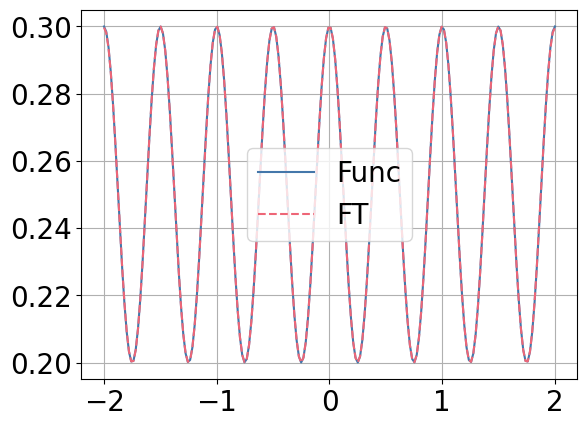

In [183]:
def sum_series(x,R,an,bn,a0=1,norm=True):
    """Sums Fourier series from coefficients."""
    assert(len(an) == len(bn)), "Too many an's or bn's!"
    cn = np.array([np.cos(2*np.pi*(i+1)*x/R) for i in range(len(an))])
    sn = np.array([np.sin(2*np.pi*(i+1)*x/R) for i in range(len(an))])
    tot = a0 + 2*(np.dot(an,cn) + np.dot(bn,sn))
    if norm: tot = tot/simpson(tot,x)
    return tot

def get_coeff(x,f,n,R,print_coeff=True):
    """Returns Fourier cosine or sine coefficient."""
    an = simpson(f*np.cos(2*np.pi*n/R*x),x)
    bn = simpson(f*np.sin(2*np.pi*n/R*x),x)
    if print_coeff: print(f'\t a{n} = {round(an,5)}, b{n} = {round(bn,5)}')
    return an,bn

def get_ana(x,f,n,R,a0=1,norm=True,print_coeff=True):
    """Returns Fourier series up to order n. a0 is given"""
    an,bn = np.zeros(n),np.zeros(n)
    if print_coeff: print(f'Fourier coefficients:')
    for n in range(n):
        an[n],bn[n] = get_coeff(x,f,n+1,R,print_coeff)
    return sum_series(x,R,an,bn,a0=a0,norm=norm)

temp = np.linspace(-2,2,200)

test_cos = 5*(5 + np.cos(temp*2*np.pi*2))
test_cos = test_cos/simpson(test_cos,temp)
test_ana = get_ana(temp,test_cos,15,4,print_coeff=True)
#test_ana = test_ana/simpson(test_ana,temp)

plt.plot(res_fine,test_cos,label='Func')
plt.plot(res_fine,test_ana,'--',label='FT')
plt.legend()
plt.show()

***
## Theoretical Solution:
***

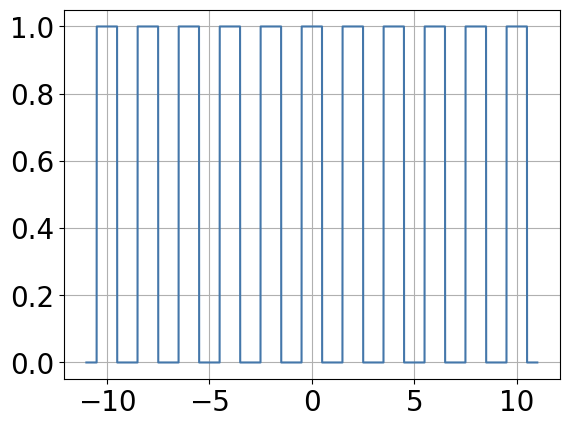

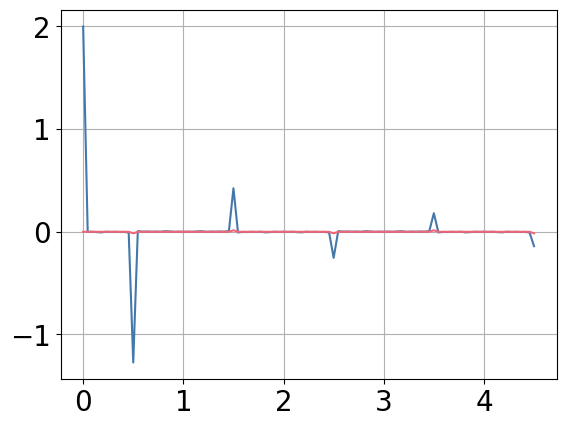

In [171]:
N = 3000
T = 22./N
x = np.linspace(-11.,11., num=bin_x, endpoint=True)
x_fine = np.linspace(-11.,11., num=N, endpoint=True)

MASK = grating(x_fine,slit_width,slit_width,slit_num,slit_offset)
FT_MASK = fft(MASK)[0:N//2]
FREQS = fftfreq(N,T)[:N//2]

plt.plot(x_fine,MASK)
plt.show()
plt.plot(FREQS[:100],2*(np.real(FT_MASK)/np.sum(MASK))[:100])
plt.plot(FREQS[:100],2*(np.imag(FT_MASK)/np.sum(MASK))[:100])
plt.show()

Normalization factor (av):  0.0004
Harmonic  1  Ana - Num= 0.06981385886254043
Harmonic  2  Ana - Num= 0.1655301875668842
Harmonic  3  Ana - Num= 0.20469557791112936
Harmonic  4  Ana - Num= 0.037963279349184476
Harmonic  5  Ana - Num= -0.2653125559673804


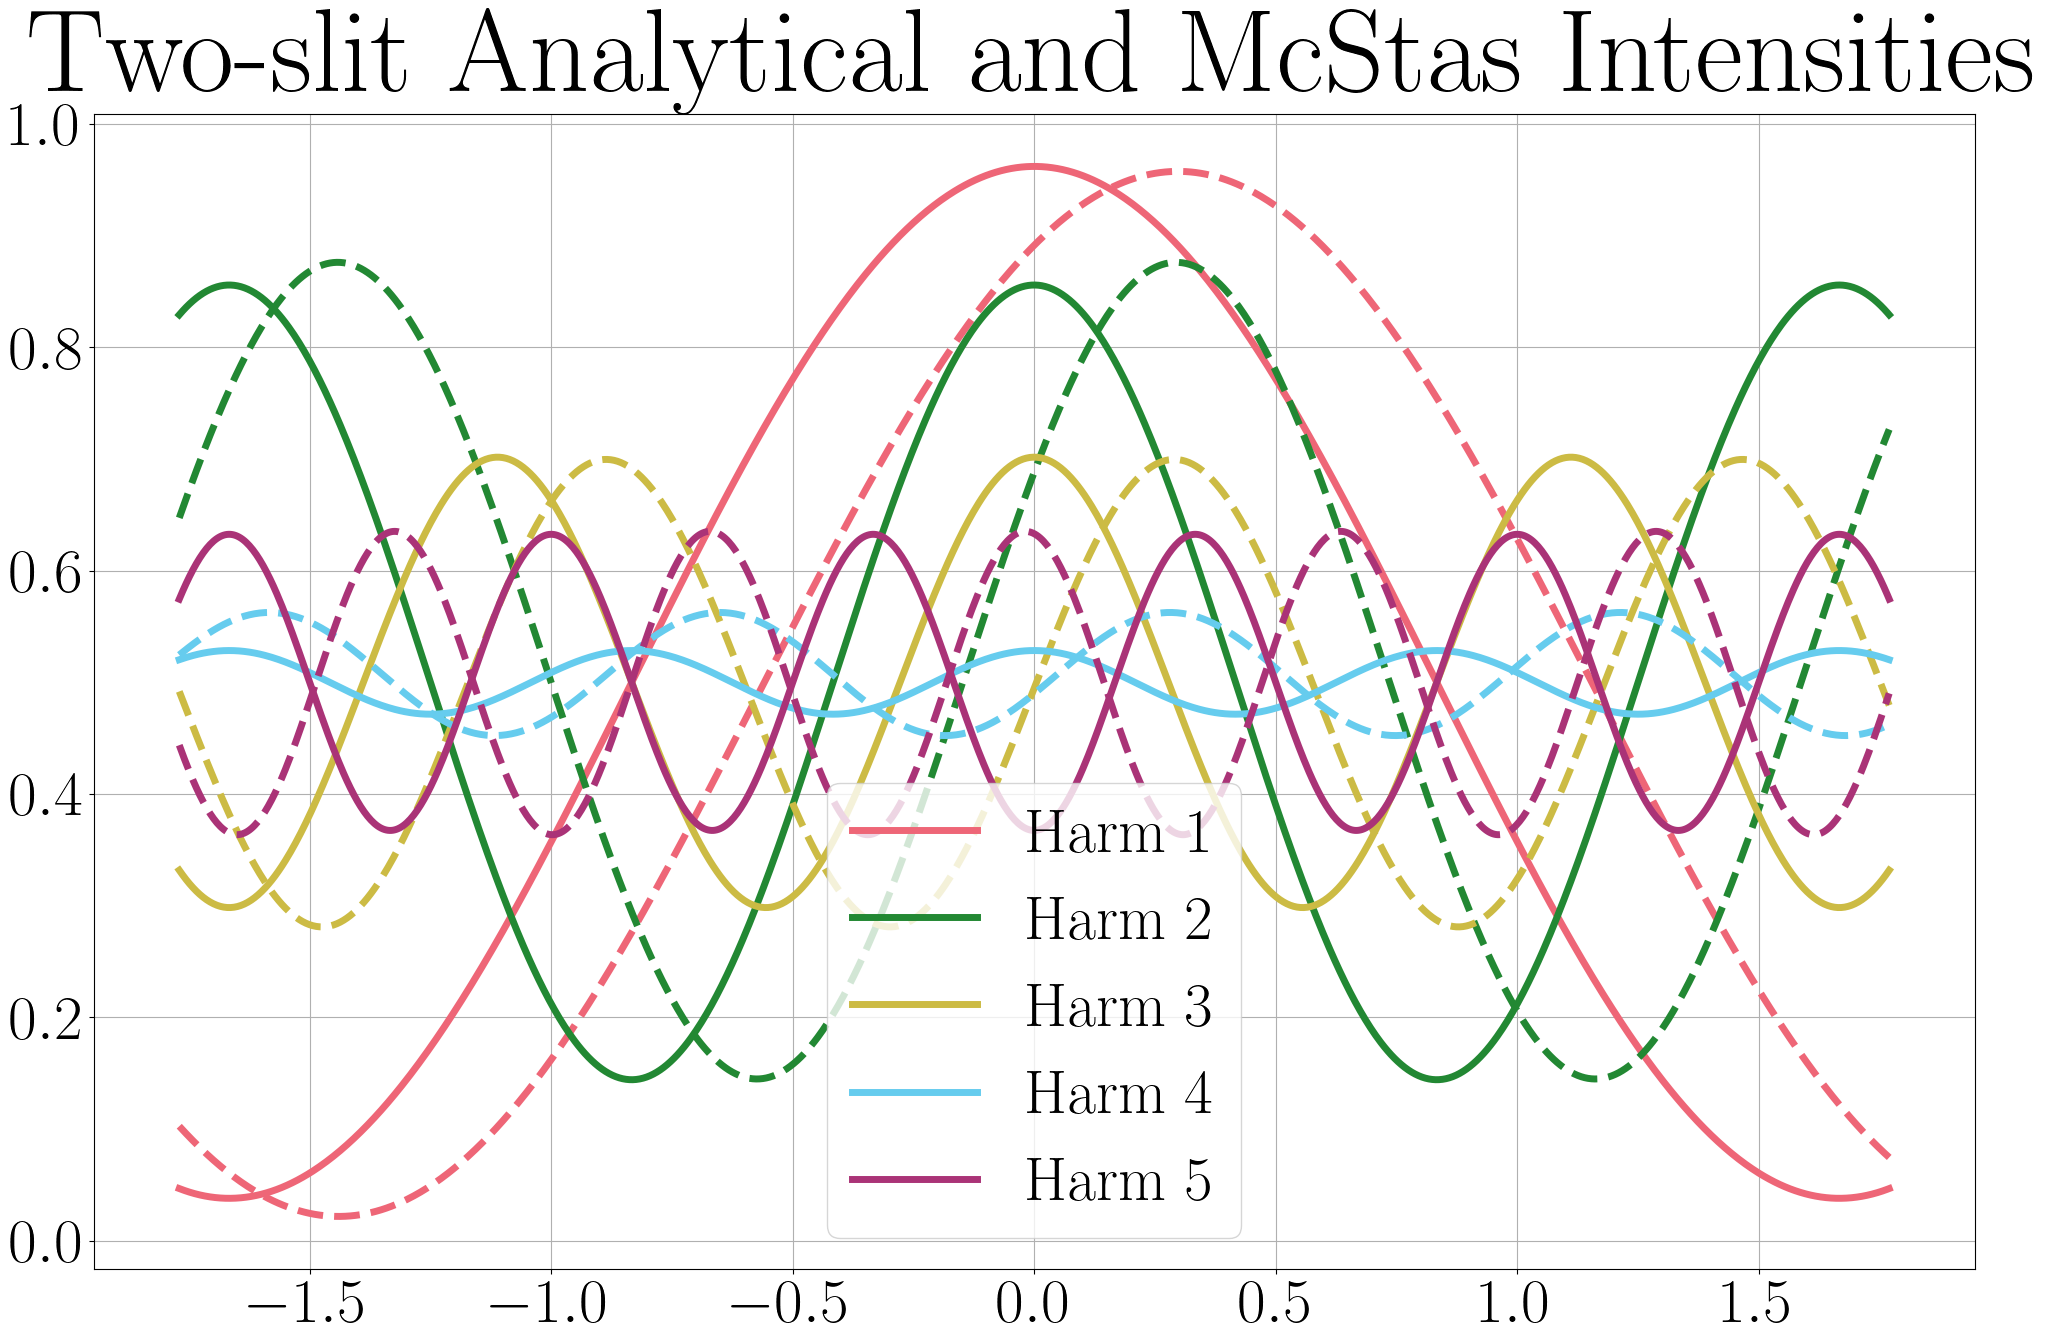

Theoretical values: 
 [0.24, 0.222, 0.171, 0.097, 0.014, -0.064, -0.122, -0.154, -0.158, -0.136]
Non-normed Numerical values: 
 [0.5, 0.785, 0.381, -0.006, -0.019, 0.265, 0.479, 0.44, 0.151, -0.171] 



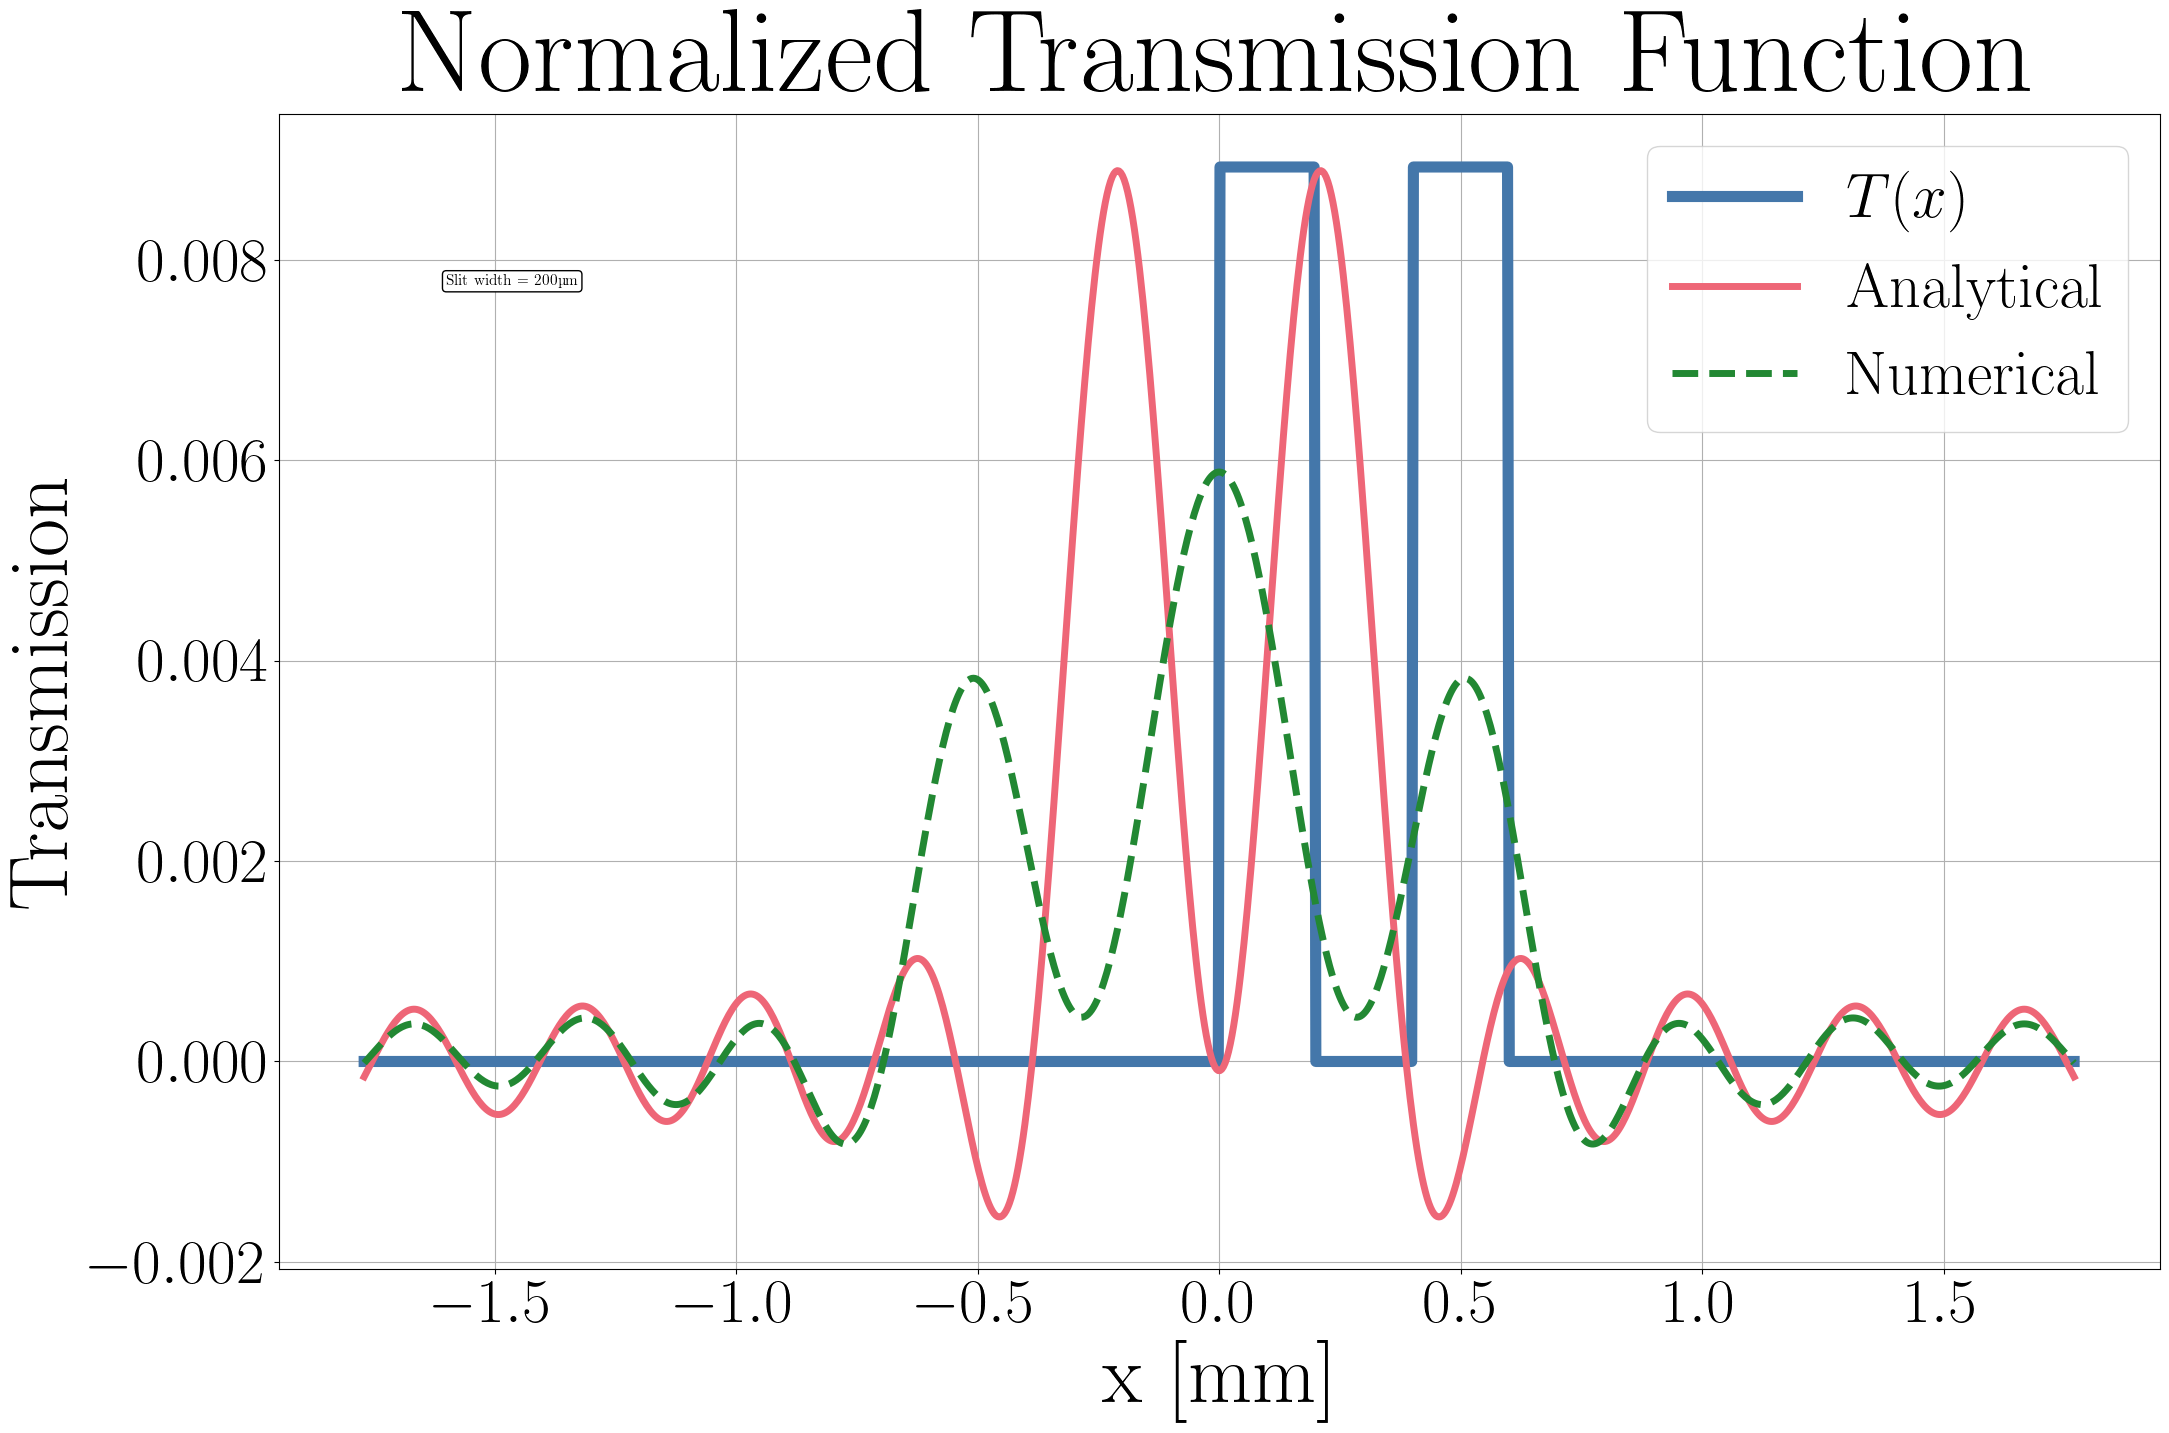

In [31]:
def slit_T(x, width):    #determines the two-slit function
    return np.heaviside(x + 3*width/2 - slit_offset, .5)*np.heaviside(-width/2 - x + slit_offset, .5) + \
            np.heaviside(x - width/2 - slit_offset, .5)*np.heaviside(3*width/2 - x + slit_offset, .5)
def slit_T_inten(x, n, width, R, ls):    #analytical intensity on the detector
    if (n == 0):
        return [2*width/ls for i in range(len(x))]    #constant term
    else:
        return width/ls + R/(np.pi*n*ls)*np.sin(np.pi*n/R*width)*np.cos(2*np.pi*n/R*width)*np.cos(2*np.pi*n/R*x)
def slit_T_coeff(x, n, width, R, ls):    #analytical solution for two-slit Fourier transform
    x0 = 500 #midpoint, hardcoded!
    if (n == 0):
        return 2*ls/R*slit_T_inten(x, 0, width, R, ls)[x0] #2 or 4?
    else:
        return 4*ls/R*slit_T_inten(x, n, width, R, ls)[x0] - slit_T_coeff(x, 0, width, R, ls)

plot_harms, plot_T_com, plot_T_norm_com = True, False, True

norm = np.asarray(slit_T_inten(xpos_finer, 0, slit_x*1e-3, res, Ls*1e3))    #normalize by zero current scan
print('Normalization factor (av): ', round(np.mean(norm),5))

if (plot_harms):
    fig = plt.figure(figsize=(plot_width,plot_height))
    plt.title('Two-slit Analytical and McStas Intensities')
    #for i in range(1,20):    #chooses which harmonics to plot
    for i in range(1,6):
        plt.plot(xpos_finer, slit_T_inten(xpos_finer, i, slit_x*1e-3, res, Ls*1e3)/norm, '-', linewidth=5, \
                 label='Harm '+str(i), color='C'+str(i))
        plt.plot(xpos_finer, simple_cos(xpos_finer, *nic_hc_fits[i-1]), '--', linewidth=5, \
                 color='C'+str(i))
        print('Harmonic ', str(i),' Ana - Num=', (slit_T_inten(xpos_finer, i, slit_x*1e-3, res, Ls*1e3)/norm)[500] - \
             simple_cos(xpos_finer, *nic_hc_fits[i-1])[500])
    plt.legend()
    plt.grid('on')
    plt.show()
    
cos_vals_ana = [slit_T_coeff(xpos_finer, i, slit_x*1e-3, res, Ls*1e3) for i in range(len(harms)+1)]
print('Theoretical values: \n', [round(i,3) for i in cos_vals_ana])
cos_vals_num = 2*np.array([simple_cos(xpos_finer, *nic_hc_fits[i])[500] for i in range(len(harms))]) - 1
cos_vals_num = np.insert(cos_vals_num, 0, 1/2, axis=0)
print('Non-normed Numerical values: \n', [round(i,3) for i in cos_vals_num], '\n')    #num*.24 = ana

recon_harms = 10
recon_ana = [cos_vals_ana[0]/2 + np.sum(np.array([cos_vals_ana[i]*np.cos(2*np.pi*i/res*x) for i in range(1,recon_harms)]), axis=0) \
         for x in xpos_finer]
recon_num = np.asarray([cos_vals_num[0] + np.sum(np.array([cos_vals_num[i]*np.cos(2*np.pi*i/res*x) \
                                for i in range(1,recon_harms)]), axis=0) for x in xpos_finer])

if (plot_T_com):
    fig = plt.figure(figsize=(plot_width,plot_height))
    plt.title("T(x) Recon.")
    plt.plot(xpos_finer, slit_T(xpos_finer, slit_x*1e-3), linewidth=5, label='$T(y)$')
    plt.plot(xpos_finer, recon_ana, '-', linewidth=5, label='Ana. Recon')
    plt.plot(xpos_finer, recon_num, '--', linewidth=5, label='Num. Recon')
    plt.legend()
    plt.grid('on')
    plt.show()

if (plot_T_norm_com):
    fig = plt.figure(figsize=(plot_width,plot_height))
    plt.title("Normalized Transmission Function")
    plt.plot(xpos_finer, slit_T(xpos_finer, slit_x*1e-3)/np.sum(slit_T(xpos_finer, slit_x*1e-3)), linewidth=8, label='$T(x)$')
    plt.plot(xpos_finer, recon_ana/np.sum(recon_ana), '-', linewidth=5, label='Analytical')
    plt.plot(xpos_finer, recon_num/np.sum(recon_num), '--', linewidth=5, label='Numerical')
    plt.text(-1.6, 7.75e-3, r'Slit width = $\num{200}\unit{\micro \meter}$', \
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=.25'))
    plt.xlabel('x ' + r'$[\unit{\milli \meter}]$')
    plt.ylabel('Transmission')
    plt.legend()
    plt.grid('on')
    plt.show()


***
## Solution animations
***

In [170]:
def AER_ani(frame):
    frame += 2
    temp_cos_vals_num = 2*np.array([simple_cos(xpos_finer, *nic_hc_fits[i])[500] for i in range(0,frame)]) - 1
    temp_cos_vals_num = np.insert(temp_cos_vals_num, 0, 1/2, axis=0)
    temp_recon_num = np.asarray([temp_cos_vals_num[0] + np.sum(np.array([temp_cos_vals_num[i]*np.cos(2*np.pi*i/res*x) \
                                for i in range(1,frame)]), axis=0) for x in xpos_finer])
    temp_recon_num = temp_recon_num/np.sum(temp_recon_num)
    ax.set_title(r'Reconstruction up to $N ='+str(frame-1)+'$')
    line.set_ydata(temp_recon_num)
    line.set_label(r'$N=$'+str(frame-1))
    plt.text(-1.6, 5e-3, r'$R_{\mathrm{AER}}=\num{'+str(round(res/frame,2))+r'}\unit{\milli \meter}$', \
             fontdict=dict(fontsize=60), bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=.25'))
    plt.legend()
    
fig = plt.figure(figsize=(plot_width,plot_height))
ax = plt.axes()
ax.plot(xpos_finer, slit_T(xpos_finer, slit_x*1e-3)/np.sum(slit_T(xpos_finer, slit_x*1e-3)), linewidth=8, label='$T(x)$')
line, = ax.plot(xpos_finer, np.zeros(len(xpos_finer)), linewidth=8)
#ax.plot(xpos_finer, np.zeros(len(xpos_finer)), '-', linewidth=5, label='Num. Recon')
#plt.plot(xpos_finer, recon_num/np.sum(recon_num), '--', linewidth=5, label='Num. Recon')
#plt.text(-1.6, 7.75e-3, r'Slit width = $\num{200}\unit{\micro \meter}$', \
#         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=.25'))
ax.set_ylim(-.002, .010)
plt.xlabel('x ' + r'$[\unit{\milli \meter}]$')
plt.ylabel('Transmission')
plt.legend()
plt.grid('on')

F_tot = 6
F_int = 200
FPS = .5
anim = FuncAnimation(fig, AER_ani, frames=F_tot, interval=F_int, repeat=False)
anim.save('Aer_soln_FPS'+str(FPS)+'_frames'+str(F_tot)+'.gif', writer='pillow', fps=FPS)
plt.close()
print('Ding!')


Ding!


In [175]:
def AER_ani(frame):
    frame += 7
    temp_cos_vals_num = 2*np.array([simple_cos(xpos_finer, *nic_hc_fits[i])[500] for i in range(0,frame)]) - 1
    temp_cos_vals_num = np.insert(temp_cos_vals_num, 0, 1/2, axis=0)
    temp_recon_num = np.asarray([temp_cos_vals_num[0] + np.sum(np.array([temp_cos_vals_num[i]*np.cos(2*np.pi*i/res*x) \
                                for i in range(1,frame)]), axis=0) for x in xpos_finer])
    temp_recon_num = temp_recon_num/np.sum(temp_recon_num)
    ax.set_title(r'Reconstruction up to $N ='+str(frame-1)+'$')
    line.set_ydata(temp_recon_num)
    line.set_label(r'$N=$'+str(frame-1))
    plt.text(-1.6, 5e-3, r'$R_{\mathrm{AER}}=\num{'+f"{round(res/frame,2):.2f}"+r'}\unit{\milli \meter}$', \
             fontdict=dict(fontsize=60), bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=.25'))
    plt.legend()
    
fig = plt.figure(figsize=(plot_width,plot_height))
ax = plt.axes()
ax.plot(xpos_finer, slit_T(xpos_finer, slit_x*1e-3)/np.sum(slit_T(xpos_finer, slit_x*1e-3)), linewidth=8, label='$T(x)$')
line, = ax.plot(xpos_finer, np.zeros(len(xpos_finer)), linewidth=8)
#ax.plot(xpos_finer, np.zeros(len(xpos_finer)), '-', linewidth=5, label='Num. Recon')
#plt.plot(xpos_finer, recon_num/np.sum(recon_num), '--', linewidth=5, label='Num. Recon')
#plt.text(-1.6, 7.75e-3, r'Slit width = $\num{200}\unit{\micro \meter}$', \
#         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=.25'))
ax.set_ylim(-.002, .011)
plt.xlabel('x ' + r'$[\unit{\milli \meter}]$')
plt.ylabel('Transmission')
plt.legend()
plt.grid('on')

F_tot = 10
F_int = 200
FPS = .5
anim = FuncAnimation(fig, AER_ani, frames=F_tot, interval=F_int, repeat=False)
anim.save('Aer_soln_higher_FPS'+str(FPS)+'_frames'+str(F_tot)+'.gif', writer='pillow', fps=FPS)
plt.close()
print('Ding!')


Ding!


X pos:  [8.34504505e-01 4.16366366e-01 2.78168168e-01 2.07297297e-01
 1.68318318e-01 1.39969970e-01 1.18708709e-01 1.04534535e-01
 9.39039039e-02 8.99625932e+02 9.02556302e+02 1.32000000e+03
 1.32000000e+03 1.65000000e+02 1.32000000e+03 1.55277778e+02
 1.33139090e+03 6.50556828e+02 1.32000000e+03 1.42455376e+03]
I_n:  [7.54024338e-01 8.40736214e-01 6.99291372e-01 5.55910396e-01
 4.68955528e-01 5.70952631e-01 7.36839006e-01 8.19818184e-01
 7.65605642e-01 8.99625932e+02 9.02556302e+02 1.32000000e+03
 1.32000000e+03 1.65000000e+02 1.32000000e+03 1.55277778e+02
 1.33139090e+03 6.50556828e+02 1.32000000e+03 1.42455376e+03]
b_n:  [ 5.08048676e-01  6.81472427e-01  3.98582743e-01  1.11820793e-01
 -6.20889439e-02  1.41905262e-01  4.73678013e-01  6.39636369e-01
  5.31211283e-01  8.99625932e+02  9.02556302e+02  1.32000000e+03
  1.32000000e+03  1.65000000e+02  1.32000000e+03  1.55277778e+02
  1.33139090e+03  6.50556828e+02  1.32000000e+03  1.42455376e+03]


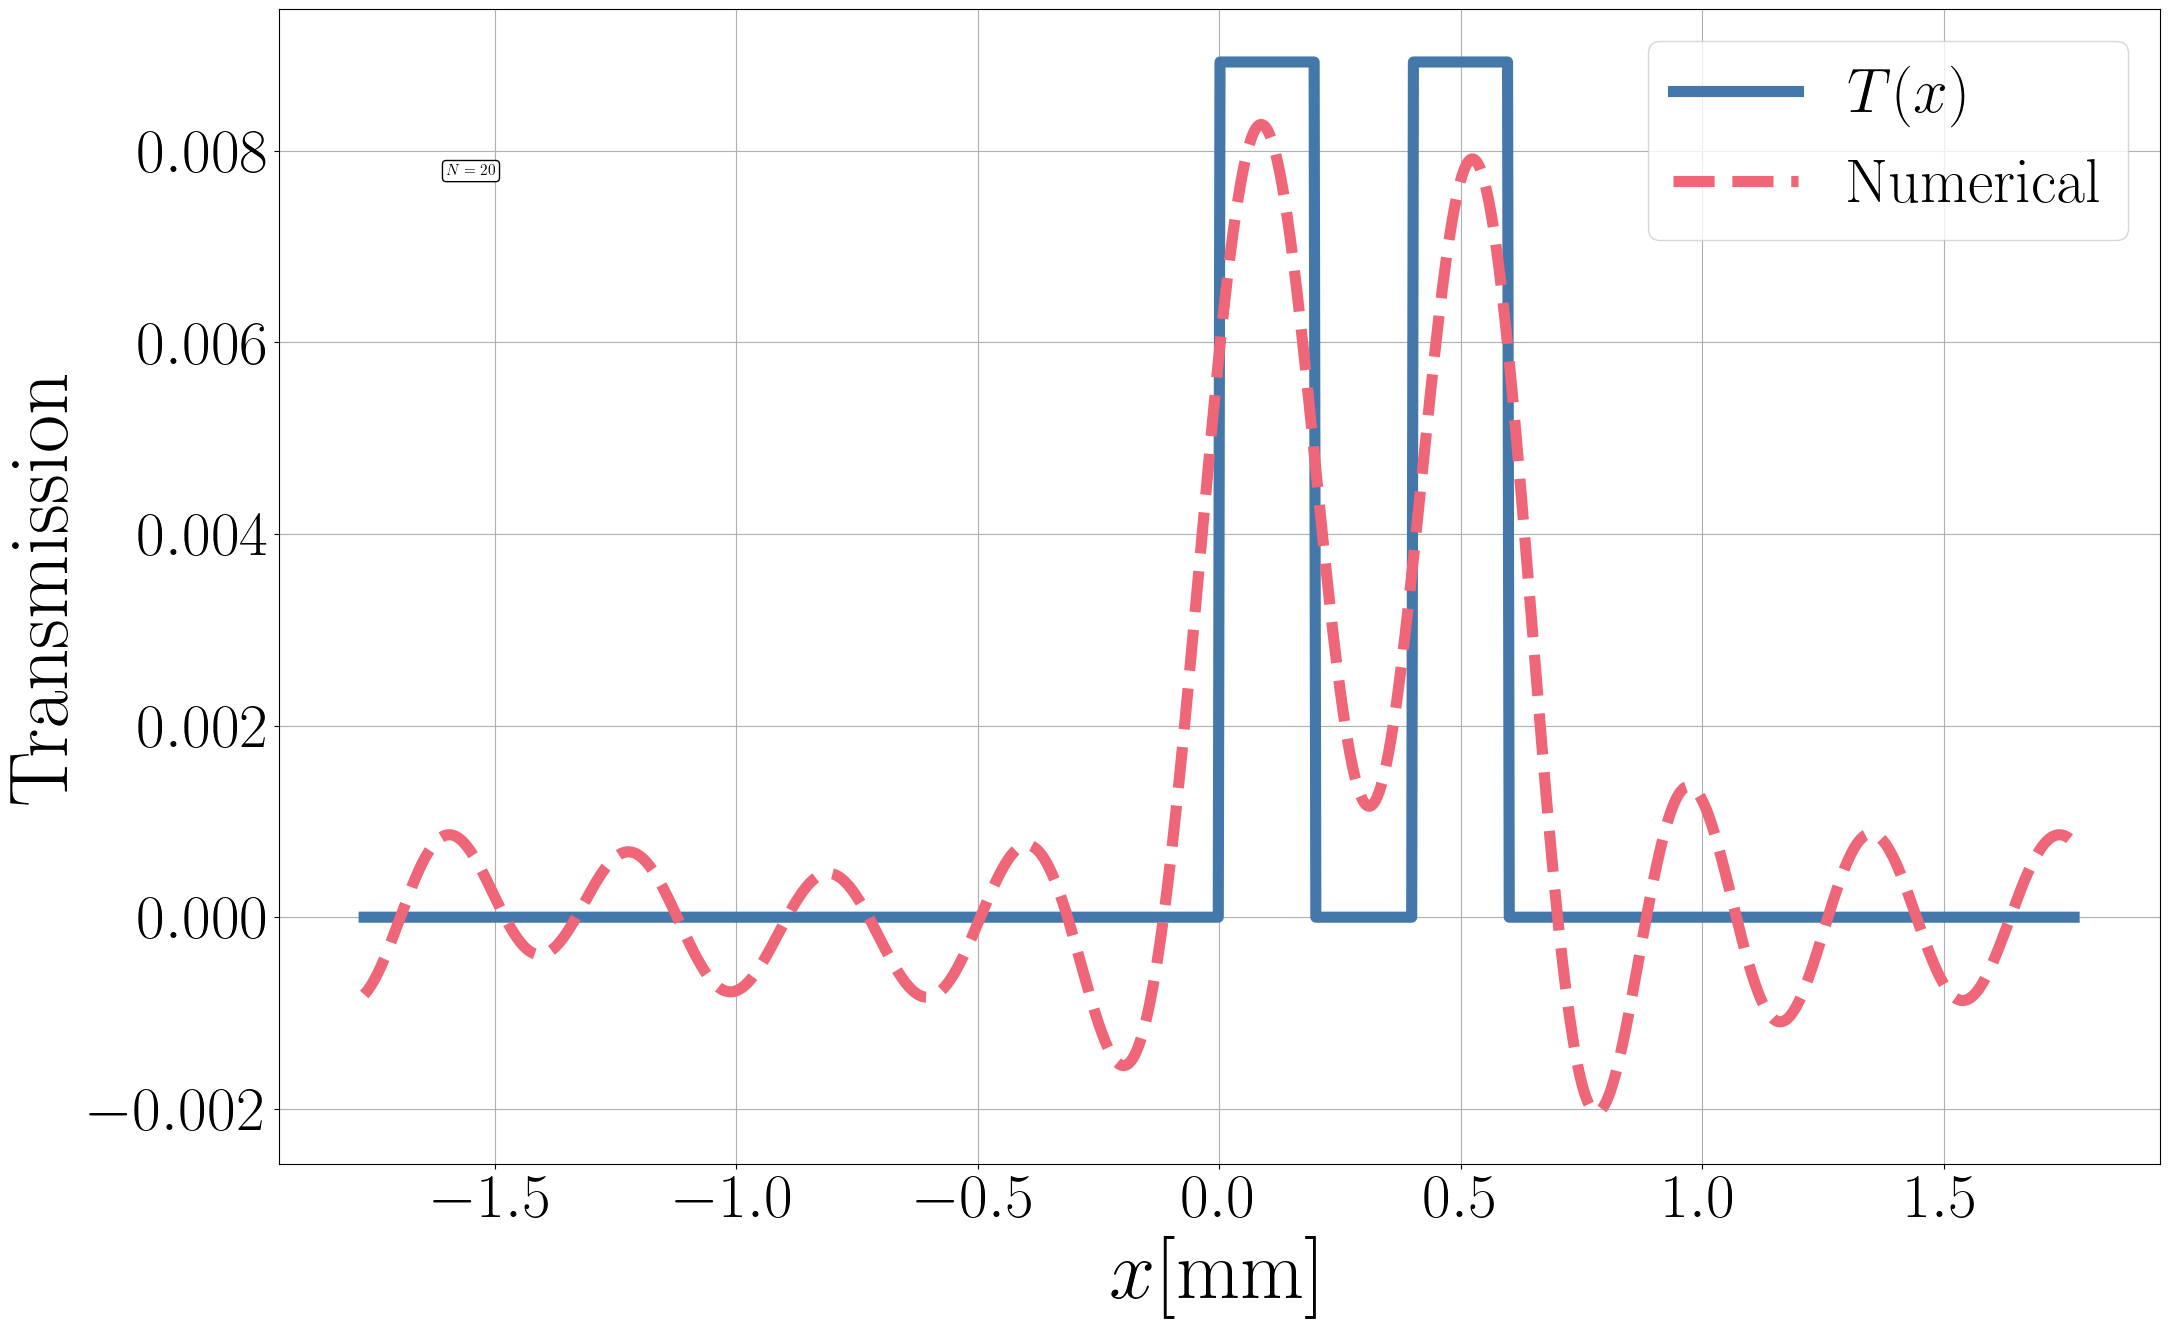

In [33]:
#Checking that the sine coefficients are zero
bn, In, xvals = np.empty(20), np.empty(20), np.empty(20)
for i in range(9):
    val = (res/(4*(i + 1)))
    indx = np.argmin(abs(xpos_finer - val))
    #plt.plot(abs(xpos_finer - val))
    #print('Diff: ', round(xpos_finer[indx]-val,3))
    xvals[i] = xpos_finer[indx]
    In[i] = simple_cos(xpos_finer, *nic_hc_fits[i])[indx]
    bn[i] = 2*simple_cos(xpos_finer, *nic_hc_fits[i])[indx] - 1
print('X pos: ', xvals)
print('I_n: ', In)
print('b_n: ', bn)

hh = 9
sine_recon_num = np.asarray([np.sum(np.array([bn[i-1]*np.sin(2*np.pi*i/res*x) \
                                for i in range(1,hh)]), axis=0) for x in xpos_finer])

#fig = plt.figure(figsize=(plot_width,plot_height))
#plt.plot(xpos_finer, sine_recon_num, label='sine', linewidth=5)
#plt.plot(xpos_finer, recon_num, label='cosine', linewidth=5)
#plt.plot(xpos_finer, sine_recon_num/np.sum(sine_recon_num + recon_num), label='normed sine', linewidth=5)
#plt.plot(xpos_finer, recon_num/np.sum(sine_recon_num + recon_num), label='normed cosine', linewidth=5)
#plt.xlabel('x ' + r'$[\unit{\milli \meter}]$')
#plt.ylabel('Transmission')
#plt.legend()
#plt.grid()
#plt.show()

fig = plt.figure(figsize=(plot_width,plot_height))
plt.plot(xpos_finer, slit_T(xpos_finer, slit_x*1e-3)/np.sum(slit_T(xpos_finer, slit_x*1e-3)), linewidth=8, label='$T(x)$')
#plt.plot(xpos_finer, recon_ana/np.sum(recon_ana), '-', linewidth=8, label='Analytical')
plt.plot(xpos_finer, (sine_recon_num + recon_num)/np.sum(sine_recon_num + recon_num), '--', label='Numerical', linewidth=8)
plt.xlabel('$x ' + r'[\unit{\milli \meter}]$')
plt.ylabel('Transmission')
plt.text(-1.6, 7.75e-3, r'$N = 20$', \
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=.25'))
plt.legend()
plt.grid()
plt.show()
